# Final Modeling 

In this notebook, we will delve into the final stages of modeling and interpretation. Our objective is to harness the power of advanced algorithms to extract deeper insights and potentially achieve better predictive performance from our dataset.

We will explore three algorithms: Logistic Regression, Random Forest, and XGBoost. We aim to investigate their performances along with different feature selection methodologies. Additionally, to possibly enhance accuracy and robustness, we'll also experiment with ensemble learning to combine the strengths of the individual models. All hyperparameters were chosen with the goal of reducing overfitting, which was an issue seen during baseline modeling.

By the end of this notebook, we hope to have a clearer understanding of the best modeling strategy for our dataset, backed by empirical results from our grid search and ensemble efforts.

*Note: Each gridsearch was run in a separate colab notebook, and the results combined here, so some variables/imports/steps may look duplicative*

## Table of Contents <a name="toc"></a>

1. [Model Evaluation](#model-evaluation)
2. [Feature Selection](#feature-selection)
3. [Logistic Regression](#logistic-regression)
4. [Logistic Regression - Variance Threshold](#logistic-regression---variance-threshold)
5. [Random Forest](#random-forest)
6. [Random Forest - Variance Threshold](#random-forest---variance-threshold)
7. [XGBoost - Variance Threshold](#xgboost---variance-threshold)
8. [Ensemble Learning](#ensemble-learning)
9. [Error Analysis](#error-analysis)
10. [Conclusions](#conclusions)
11. [Further Evaluation](#further-evaluation)

## Model Evaluation <a name="model-evaluation"></a>

Properly assessing the performance and understanding the strengths and weaknesses of our models is crucial for both improving them and for making informed decisions based on their outputs. Here's a breakdown of what we'll be exploring for each model:

1. **Best Parameters:** We'll start by looking at the best hyperparameters for each model. By documenting the best parameters, we gain insights into the configurations that work best for our specific problem.
2. **ROC Curve:** By visualizing the trade-offs between true positive rate (sensitivity) and false positive rate (1-specificity), we can gauge the overall performance of our classifier.
3. **Classification Report:** These metrics provide a comprehensive view of how well our model is performing for each category and highlights areas that might need more attention.
4. **Confusion Matrix:** This gives us a clear picture of where our model is making correct predictions and where it's going wrong, helping us identify potential areas of improvement.
5. **Coefficients for Logistic Regression Models:** Gaining insights into the importance and impact of each feature on our prediction to help us understand the relationships and significance of our features in the context of the problem.

Each of these elements offers a unique perspective on the models and together, provide a comprehensive view of performance, ensuring we're not just relying on a single metric, but truly understanding our models from multiple angles.

---

While it's generally ideal to incorporate all data pre-processing steps within a comprehensive pipeline to ensure reproducibility and streamline the workflow, time constraints and the project's scope led us to adopt a quicker approach. We'll be working directly with the final dataframe crafted in our preceding notebook. We'll start by importing our dataset and preparing our train and test variables.

In [1]:
# Import libraries
import pandas as pd
import numpy as np

In [2]:
# Import final test dataframe
test = pd.read_csv('/content/drive/MyDrive/data/new_test_final.csv')

In [3]:
# Import final train datafram
train = pd.read_csv('/content/drive/MyDrive/data/new_train_final.csv')

In [4]:
# Define X
X_train = train.drop(columns=['imdb_id', 'rating_category', 'cleaned_review'])
X_test = test.drop(columns=['imdb_id', 'rating_category', 'cleaned_review'])

In [5]:
y_train = train['rating_category']
y_test = test['rating_category']

We will also define a function to retreived post-gridsearch metrics for each of our models. 

In [76]:
# Importing the required libraries
from sklearn.metrics import accuracy_score

# Function for post grid search analysis
def post_grid_search_analysis(grid_search, X_test, y_test):
    # Get the best parameters
    best_params = grid_search.best_params_

    # Predict on the test set
    y_pred = grid_search.best_estimator_.predict(X_test)

    # Get the probability scores for the test set 
    y_score = grid_search.best_estimator_.predict_proba(X_test)

    # Calculate the test accuracy
    test_accuracy = accuracy_score(y_test, y_pred)

    # Get the best score 
    best_score = grid_search.best_score_

    results = {
        'Best Parameters': best_params,
        'Best Score': best_score,
        'Test Accuracy': test_accuracy
    }

    return results

## Feature Selection <a name="feature-selection"></a>

### Feature Selection Methods: Variance Threshold vs SelectFromModel

In our analysis, we experimented with two different feature selection techniques: Variance Threshold and SelectFromModel.

#### Variance Threshold:
- **What it Does**: Removes low-variance features baed on a threshold, assuming features with low variance do not contribute much to the model's predictive power.
- **How it Works**: Set a threshold below which all features with variance will be removed. In our case, we used very low thresholds like 0.0005 and 0.0009 to ensure only very constant features would be removed.
- **Why Used**: Computationally less expensive and works well with a high-dimensional feature space. 

#### SelectFromModel:
- **What it Does**: Uses another machine learning model to select the most important features based on feature importances or coefficients.
- **How it Works**: Fits the model and uses a threshold to select features whose importance is above that threshold.
- **Why Used**: More sophisticated and tends to yield better results in terms of feature selection, but computationally more expensive.

By using both methods in different models, we aim to balance computational efficiency with model performance.

[Back to Top](#toc)

---

## Logistic Regression <a name="logistic-regression"></a>

### Why Choose Logistic Regression?

Logistic Regression is a simple yet powerful linear model for binary or multiclass classification problems. It's also computationally inexpensive, offers interpretability, allowing us to understand the impact of individual features on the predicted outcome.

#### Chosen Hyperparameters

1. **`feature_selection__threshold`: [None, "mean"]**  
   - `SelectFromModel` for feature selection. The threshold is either `None` (keep all features) or based on the mean of the feature coefficients.
   - `VarianceThrshold` for feature seletion. The thresholds are 0.0005 and 0.0009, based on previous baseline modeling results.<br>  
<br> 
2. **`classification__C`: [0.1, 1]**  
   - The inverse regularization strength. Smaller values specify stronger regularization, which can help prevent overfitting.<br>  
<br>
3. **`classification__solver`: ['saga']**  
   - Algorithm to use in the optimization problem. 'saga' is appropriate for large datasets and can handle L1 penalty.<br>  
<br>
4. **`classification__penalty`: ['l1', 'elasticnet']**  
   - Specifies the norm used in the penalization. L1 leads to sparse solutions, helping in feature selection, while 'elasticnet' is a mix of L1 and L2 penalties.<br>  
<br>
5. **`classification__l1_ratio`: [0.5]**  
   - The Elastic-Net mixing parameter. This is only used when penalty is 'elasticnet'. A value of 0.5 balances both L1 and L2 penalties.
   
The hyperparameters are chosen to provide a balance between performance and interpretability, and are optimized to mitigate the risk of overfitting.

### Pipeline & ParamGrid

Now we'll define our pipeline and paramgrid with the aforementioned hyperparameters.

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV

# Define the pipeline
logistic_pipeline = Pipeline([
    ('feature_selection', SelectFromModel(LogisticRegression(max_iter=1000))),
    ('classification', LogisticRegression(max_iter=1000))
])

In [21]:
# Define parameter grid
param_grid_logreg = {
    'feature_selection__threshold': [None, "mean"],
    'classification__C': [0.1, 1],
    'classification__solver': ['saga'],
    'classification__penalty': ['l1', 'elasticnet'],
    'classification__l1_ratio': [0.5]
}

In [22]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(logistic_pipeline, param_grid_logreg, cv=5, n_jobs=-1, verbose=2, error_score='raise')
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('feature_selection',
                                        SelectFromModel(estimator=LogisticRegression(max_iter=1000))),
                                       ('classification',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'classification__C': [0.1, 1],
                         'classification__l1_ratio': [0.5],
                         'classification__penalty': ['l1', 'elasticnet'],
                         'classification__solver': ['saga'],
                         'feature_selection__threshold': [None, 'mean']},
             verbose=2)

Saving the trained model: 

In [91]:
import joblib

# Save the trained model
joblib.dump(grid_search.best_estimator_, '/content/drive/MyDrive/data/logreg_model.pkl')

['/content/drive/MyDrive/data/logreg_model.pkl']

Now that the model is trained, we can get the best parameters and results:

### Best Params, Results & Summary

In [77]:
# Execute the function and store the results
results_logreg = post_grid_search_analysis(grid_search, X_test, y_test)

# Print the results
print(f"Best Log Reg Parameters: {results_logreg['Best Parameters']}")
print(f"Best Log Reg Score: {results_logreg['Best Score']}")
print(f"Log Reg Test Accuracy: {results_logreg['Test Accuracy']}")

Best Log Reg Parameters: {'classification__C': 1, 'classification__l1_ratio': 0.5, 'classification__penalty': 'l1', 'classification__solver': 'saga', 'feature_selection__threshold': None}
Best Log Reg Score: 0.6365957446808511
Log Reg Test Accuracy: 0.6348873755893137


#### Logistic Regression Model Summary

#### Hyperparameters and Feature Selection:
- **Feature Selection Method**: `SelectFromModel` with no threshold (`None`)
- **Regularization Strength (C)**: 1
- **Solver**: SAGA
- **Penalty**: L1
- **L1 Ratio**: 0.5

#### Performance:
- **Best Cross-Validated Training Score**: 0.637
- **Test Accuracy**: 0.635

#### Observations:
- We used `GridSearchCV` to find the best hyperparameters for our logistic regression model.
- The feature selection method used was `SelectFromModel` with no threshold.
- A regularization strength (`C`) of 1 and an L1 penalty were used to add just enough complexity to the model without overfitting.
- Despite the complexity of the feature space, the model achieved a similar test accuracy to the best training score, indicating that it generalizes well to new, unseen data.

### Coefficients
Now we can look at the coefficients from our model.

In [93]:
from sklearn.preprocessing import label_binarize

# Get class labels from the trained model
class_labels = grid_search.best_estimator_.named_steps['classification'].classes_

# Binarize y_test
y_test_binarized = label_binarize(y_test, classes=class_labels)

# Predict on the test set
y_pred_logreg = grid_search.best_estimator_.predict(X_test)
y_score_logreg = grid_search.best_estimator_.predict_proba(X_test)

Since we used feature selection, we need to create a mask with the features that were kept.

In [74]:
# Get the logistic regression model from the best_estimator_ attribute
logistic_model = grid_search.best_estimator_.named_steps['classification']

# Get the classes from the logistic regression model
classes = logistic_model.classes_

# Get the coefficients
coefficients = logistic_model.coef_

# Get the feature selection step from the best_estimator_ attribute
feature_selection_model = grid_search.best_estimator_.named_steps['feature_selection']

# Get the mask of kept features
mask = feature_selection_model.get_support()

# Get the names of the features that were kept
feature_names = X_train.columns[mask]

# Create a DataFrame for the coefficients
coef_df = pd.DataFrame(coefficients, columns=feature_names)

# Label the rows with the class names
coef_df['class'] = classes

# Set 'class' as the index
coef_df.set_index('class', inplace=True)

# Sort the DataFrame
sorted_coef = coef_df.T.sort_values(by=classes[0], ascending=False)

In [75]:
# Dispaly sorted coefficients
sorted_coef.head(20)

class,Average,Excellent,Good,Poor
budget,1.182112,-2.156219,-0.348253,1.304628
unigram_nice,1.166454,-1.237323,0.322850,-0.253378
unigram_lot,1.034401,-0.886278,-0.170082,0.021960
unigram_interesting,0.984818,-1.417371,0.489966,-0.057431
unigram_premise,0.956685,-0.528887,-0.151412,-0.043800
unigram_little,0.954271,-0.665395,0.302496,-0.591493
unigram_isnt,0.934380,-1.431557,-0.360358,0.857536
unigram_gore,0.927737,-0.980052,-0.912535,0.968331
unigram_want,0.904242,-0.902669,0.000000,0.000000
unigram_decent,0.885624,-1.716742,-0.733041,1.564160


We can also plot the coefficients to represent them visually:

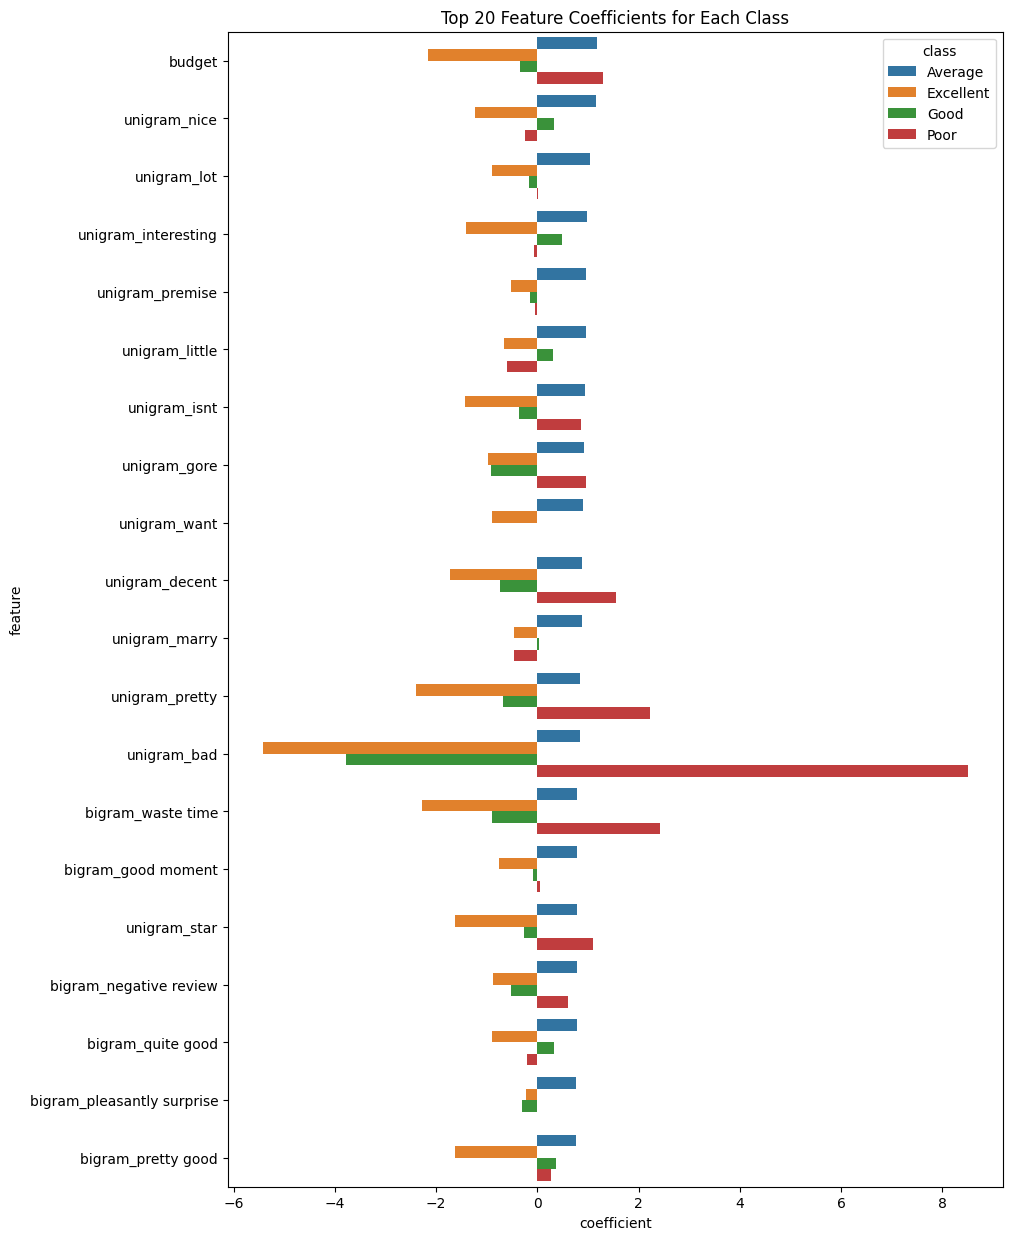

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# let's consider only the first 20 features for better visibility
top_n = 20
sorted_coef_top_n = sorted_coef.head(top_n).reset_index()
sorted_coef_top_n = sorted_coef_top_n.rename(columns={'index': 'feature'})
melted_coef = pd.melt(sorted_coef_top_n, id_vars='feature', var_name='class', value_name='coefficient')

# Plotting
plt.figure(figsize=(10, 15))
sns.barplot(x='coefficient', y='feature', hue='class', data=melted_coef)
plt.title('Top {} Feature Coefficients for Each Class'.format(top_n))
plt.show()

#### Insights based on Coefficients:

1. **Budget**: It has a positive correlation with the "Poor" and "Average" classes, and a negative correlation with the "Excellent" class. This could imply that a higher budget is not necessarily indicative of a movie being excellent according to IMDb ratings.

2. **Unigram/Bigram Text Features**: These are individual words or pairs of words that have been identified as important by the model. For example, the unigram "nice" has a positive correlation with the "Average" class but a negative correlation with the "Excellent" class. This could suggest that reviews describing a movie as "nice" are more likely to result in an "Average" rating.

3. **Variance Across Classes**: Features like "unigram_bad" have significant positive and negative coefficients across different classes ("Poor" and "Excellent", respectively). This indicates that the word "bad" is a strong predictor for distinguishing between poor and excellent movies.

4. **High Magnitude Coefficients**: Words like "unigram_bad" have a high absolute value of the coefficient for the "Poor" class, indicating they are strong predictors for that class.

Again, these coefficients give us an indication of the relationship between features and the output variable, but they do not imply causation.

### ROC Curve

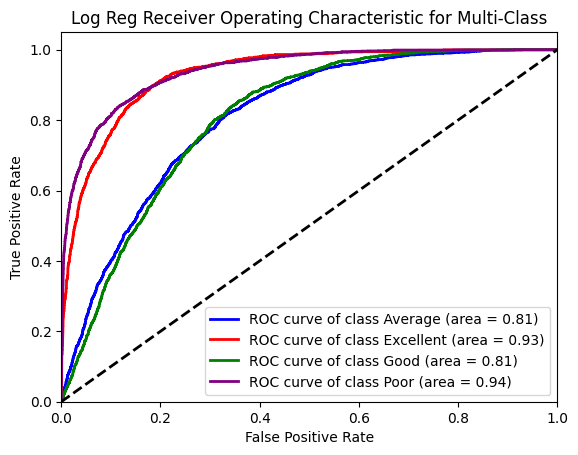

In [94]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Use the y_test_binarized we created earlier
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score_logreg[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure()
colors = cycle(['blue', 'red', 'green', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Log Reg Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()


#### ROC Curve Insights:

- **Excellent class**: AUC = 0.93. This is very high, suggesting the model does an excellent job of distinguishing between movies that are 'Excellent' and those that aren't.
- **Poor class**: AUC = 0.94. This is also very high, suggesting the model effectively identifies 'Poor' movies.
- **Average & Good classes**: AUC = 0.81 for both. These values are reasonably high but indicate that the model may have some challenges distinguishing 'Average' and 'Good' movies compared to the other classes.

- **Highly Effective for Extremes**: The model excels at identifying movies that are either 'Excellent' or 'Poor', as evidenced by the very high AUC values for these classes.
  
- **Moderate Effectiveness for Middle Ground**: While the model still performs above chance for 'Average' and 'Good' movies, it's less effective for these categories compared to the extremes. This could indicate that the characteristics defining an average or good movie are subtler and harder to pin down.
  
- **Overall Strong Performance**: Considering that all AUC values are significantly above 0.5 (random guessing), the model demonstrates strong overall performance across all classes.

### Classification Report
We can also look at the classification report to get the precision, recall, and f1 scores.

In [86]:
from sklearn.metrics import classification_report

# Generate classification report
logreg_report = classification_report(y_test, y_pred_logreg, target_names=class_labels, output_dict=True)

# Convert the classification report to a dataframe
logreg_report_df = pd.DataFrame(logreg_report).transpose()

In [87]:
# Display report 
logreg_report_df

,precision,recall,f1-score,support
Average,0.533884,0.510269,0.521809,1899.000000
Excellent,0.720023,0.712259,0.716120,1762.000000
Good,0.519864,0.541919,0.530663,1980.000000
Poor,0.770109,0.777444,0.773759,1995.000000
accuracy,0.634887,0.634887,0.634887,0.634887
macro avg,0.635970,0.635473,0.635588,7636.000000
weighted avg,0.634917,0.634887,0.634767,7636.000000


**Logistic Regression Performance Analysis:**

1. **Excellent Movies**:
    - **Precision**: 72.00% of movies predicted as 'Excellent' were indeed classified as 'Excellent'.
    - **Recall**: Among the actual 'Excellent' movies in the dataset, 71.23% were correctly recognized by the model.
    - **F1-Score**: Achieving an F1-Score of 71.61%, the model has a balanced performance for the 'Excellent' category.<br>
<br>
2. **Poor Movies**:
    - **Precision**: 77.01% of movies predicted as 'Poor' turned out to be correctly classified.
    - **Recall**: 77.74% of the actual 'Poor' movies were successfully detected by the model.
    - **F1-Score**: With an F1-Score of 77.38%, the model has a balanced accuracy for the 'Poor' movies.
<br>
<br>
3. **Average Movies**:
    - **Precision**: The model had a precision of 53.39% for 'Average' movies.
    - **Recall**: Of all the movies labeled as 'Average', the model captured 51.03% correctly.
    - **F1-Score**: The F1-Score stands at 52.18% for 'Average' movies, signifying a middle ground between precision and recall.
<br>
<br>
4. **Good Movies**:
    - **Precision**: For movies predicted as 'Good', 51.99% were correct.
    - **Recall**: Among the actual 'Good' movies, the model was accurate for 54.19% of them.
    - **F1-Score**: With an F1-Score of 53.07%, the model displays a fairly balanced performance for 'Good' movies.
<br>
<br>
5. **Overall Performance**:
    - The model's **accuracy** was 63.49%, suggesting it correctly predicted the movie ratings for nearly 64 out of every 100 movies.
    - Both the **macro average** and **weighted average** metrics are closely aligned, around the 63.5%, indicating a balanced performance across various classes.

### Confusion Matrix
Finally, we can also take a look at the confusion matrix.

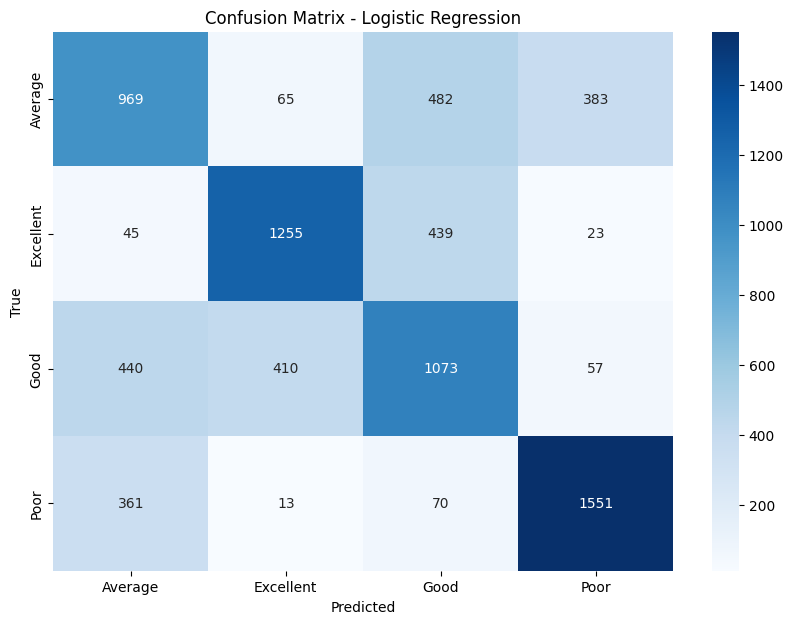

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate a confusion matrix for test and predicted labels
cm_logreg = confusion_matrix(y_test, y_pred_logreg)

# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

- **Overall Model Performance:** 
  - The model appears to perform well in distinguishing between the "Excellent" and "Poor" categories, as indicated by the relatively high true positives in these classes (1255 for "Excellent" and 1551 for "Poor").<br>  
<br>
- **"Average" Category Insights:** 
  - The model correctly classifies 969 movies as "Average". 
  - However, there is a significant number of movies (482) that were falsely classified as "Excellent" when they were actually "Average".<br>  
<br>
- **"Excellent" Category Insights:** 
  - While 1255 movies were accurately classified as "Excellent", a noticeable number (439) were misclassified as "Good".<br>  
<br>
- **"Good" Category Insights:** 
  - The "Good" category has a dispersed set of predictions. While 1073 movies were correctly identified, a considerable number of movies (440) were misclassified as "Average".<br>  
<br>
- **"Poor" Category Insights:** 
  - The model has a strong performance in identifying "Poor" movies with 1551 correct classifications. 
  - However, 361 "Poor" movies were mistakenly identified as "Average". <br>  
<br>
- **Misclassifications:** 
  - The model tends to misclassify between adjacent categories. For instance, "Average" movies getting classified as "Good" or "Excellent", and "Good" movies getting classified as "Average" or "Excellent".<br>  
<br>
- **Least Common Misclassification:** 
  - Again we see that the model rarely misclassifies between the "Excellent" and "Poor" categories, as seen with the low numbers (23 and 13 respectively) in those cells.<br>  
<br>

[Back to Top](#toc)

---

## Logistic Regression - Variance Threshold <a name="logistic-regression---variance-threshold"></a>

Now, we'll run another Logistic Regression model using Variance Threshold for feature selection, along with the same chose hyperparameters.

### Pipeline & ParamGrid

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV

# Define the pipeline
logistic_pipeline = Pipeline([
    ('variance_threshold', VarianceThreshold()),
    ('classification', LogisticRegression(max_iter=1000))
])

In [8]:
# Define parameter grid
param_grid_logreg = {
    'variance_threshold__threshold': [0.0005, 0.0009],
    'classification__C': [0.1, 1],
    'classification__solver': ['saga'],
    'classification__penalty': ['l1', 'elasticnet'],
    'classification__l1_ratio': [0.5]
}

In [9]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(logistic_pipeline, param_grid_logreg, cv=5, n_jobs=-1, verbose=3, error_score='raise')
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('variance_threshold',
                                        VarianceThreshold()),
                                       ('classification',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'classification__C': [0.1, 1],
                         'classification__l1_ratio': [0.5],
                         'classification__penalty': ['l1', 'elasticnet'],
                         'classification__solver': ['saga'],
                         'variance_threshold__threshold': [0.0005, 0.0009]},
             verbose=3)

Saving the trained model:

In [10]:
import joblib

# Save the trained model
joblib.dump(grid_search.best_estimator_, '/content/drive/MyDrive/data/logreg_vt_model.pkl')

['/content/drive/MyDrive/data/logreg_vt_model.pkl']

### Best Params, Results & Summary

Getting best parameters and results:

In [13]:
# Execute the function and store the results
results_logreg = post_grid_search_analysis(grid_search, X_test, y_test)

# Print the results
print(f"Best Log Reg (VT) Parameters: {results_logreg['Best Parameters']}")
print(f"Best Log Reg (VT) Score: {results_logreg['Best Score']}")
print(f"Log Reg Test (VT) Accuracy: {results_logreg['Test Accuracy']}")

Best Log Reg (VT) Parameters: {'classification__C': 1, 'classification__l1_ratio': 0.5, 'classification__penalty': 'elasticnet', 'classification__solver': 'saga', 'variance_threshold__threshold': 0.0005}
Best Log Reg (VT) Score: 0.6276268412438625
Log Reg Test (VT) Accuracy: 0.639601885804086


#### Logistic Regression (VT) Model Summary

**Model Configuration:**
- **Feature Selection:** Variance Threshold with a threshold value of 0.0005.
- **Classifier:** Logistic Regression with parameters optimized through grid search.
- **Hyperparameters:**
    - `C`: 1
    - `l1_ratio`: 0.5
    - `penalty`: 'elasticnet'
    - `solver`: 'saga'

**Performance Metrics:**
- **Best Training Score:** 0.6276
- **Test Accuracy:** 0.6396

**Interpretation:**
The optimized Logistic Regression model using Variance Threshold achieved a training accuracy of approximately 62.76% during cross-validation and a test accuracy of 63.96%. The model utilized a variance threshold of 0.0005 for feature selection. The model showcases a solid performance on the dataset, indicating that the variance threshold method, combined with Logistic Regression, effectively captures the underlying patterns in the data.

### Coefficients
Now we can look at the coefficients from our model.

In [19]:
# Get the logistic regression model from the best_estimator_ attribute
logistic_model = grid_search.best_estimator_.named_steps['classification']

# Get the variance threshold model from the best_estimator_ attribute
variance_threshold_model = grid_search.best_estimator_.named_steps['variance_threshold']

# Get the mask of kept features
mask = variance_threshold_model.get_support()

# Get the names of the features that were kept
feature_names = X_train.columns[mask]

# Get the classes from the logistic regression model
classes = logistic_model.classes_

# Get the coefficients
coefficients = logistic_model.coef_

# Create a DataFrame for the coefficients
coef_df_vt = pd.DataFrame(coefficients, columns=feature_names)

# Label the rows with the class names
coef_df_vt['class'] = classes

# Set 'class' as the index
coef_df_vt.set_index('class', inplace=True)

# Sort the DataFrame
sorted_coef_vt = coef_df_vt.T.sort_values(by=classes[0], ascending=False)

In [21]:
# Show coef dataframe
sorted_coef_vt.head(20)

class,Average,Excellent,Good,Poor
unigram_good,1.359727,-2.424082,-0.151799,1.216152
budget,1.343083,-2.345678,-0.484332,1.486933
unigram_lot,0.967215,-0.955232,-0.209650,0.197637
unigram_marry,0.904540,-0.817299,-0.186840,0.100716
unigram_want,0.825421,-0.943835,-0.068470,0.186133
bigram_waste time,0.792586,-2.386443,-0.927928,2.522038
unigram_little,0.789692,-0.539507,0.419117,-0.669333
bigram_negative review,0.760309,-1.006905,-0.635606,0.882203
unigram_gore,0.730878,-0.277172,-0.028424,-0.258684
bigram_lead man,0.726922,-0.251298,-0.471580,0.000000


We can also plot the coefficients to see them visually represented:

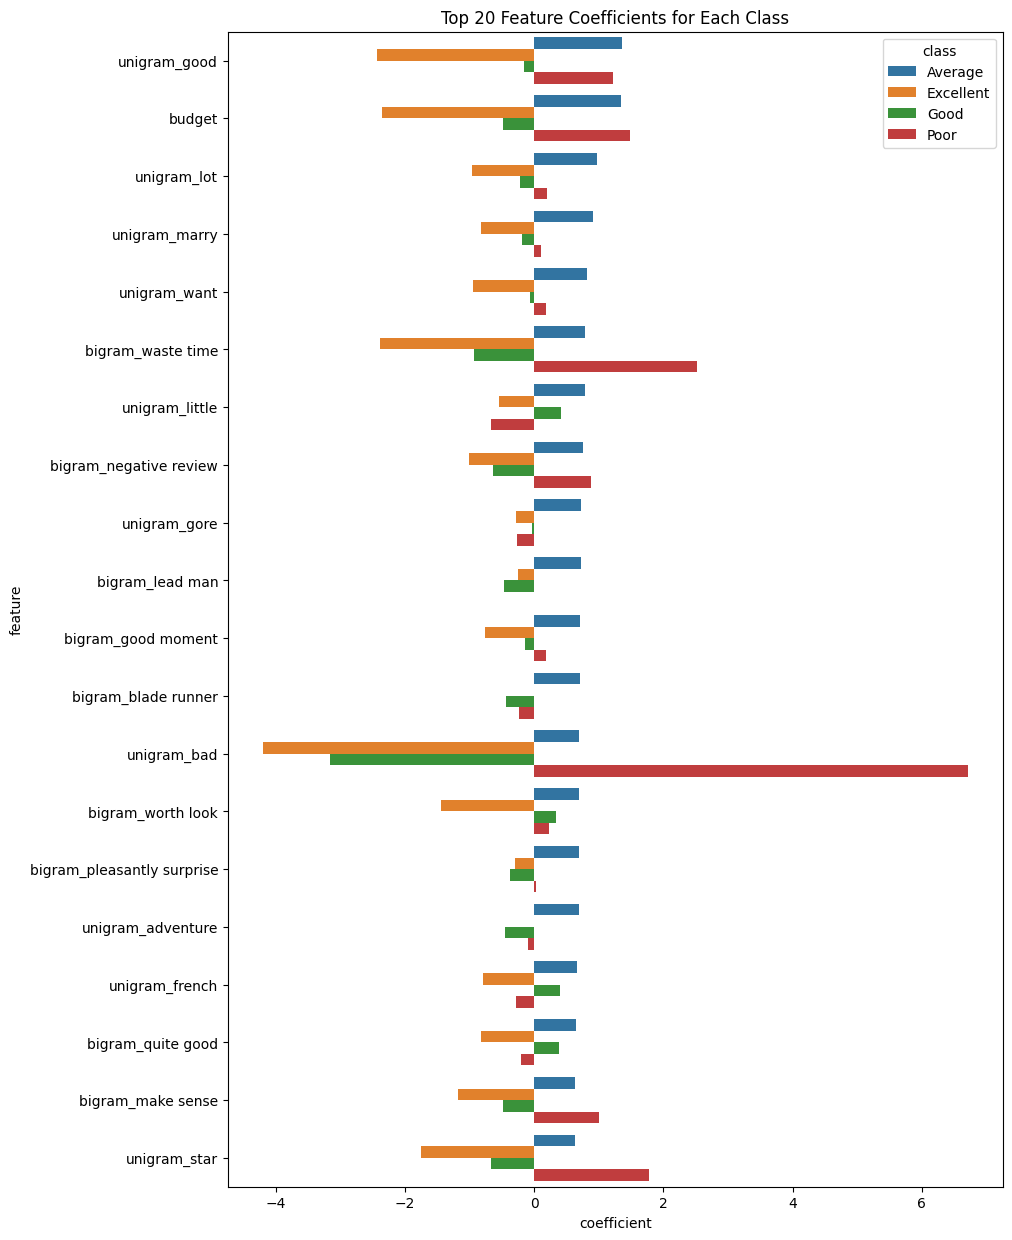

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# let's consider only the first 20 features for better visibility
top_n = 20
sorted_coef_top_n = sorted_coef_vt.head(top_n).reset_index()
sorted_coef_top_n = sorted_coef_top_n.rename(columns={'index': 'feature'})
melted_coef = pd.melt(sorted_coef_top_n, id_vars='feature', var_name='class', value_name='coefficient')

# Plotting
plt.figure(figsize=(10, 15))
sns.barplot(x='coefficient', y='feature', hue='class', data=melted_coef)
plt.title('Top {} Feature Coefficients for Each Class'.format(top_n))
plt.show()

**Top Coefficients (with Variance Threshold):**
1. **unigram_good:** This feature has a strong positive correlation with "Average" and "Poor" ratings and a negative one with "Excellent".
2. **budget:** The budget positively correlates with "Average" and "Poor" ratings, while it's negatively associated with "Excellent" and "Good".
3. **unigram_bad:** This word heavily correlates with the "Poor" category, suggesting that its presence indicates a poor rating.
4. **bigram_waste time:** It's positively associated with "Poor" ratings, hinting that mentioning "waste time" typically indicates poor reviews.
5. **bigram_negative review:** This bigram has a positive association with "Poor" and a negative one with "Excellent" and "Good".
6. **unigram_star:** It's positively correlated with the "Poor" rating but negatively with "Excellent" and "Good".
7. **bigram_make sense:** Positive correlation with "Poor" and negative with "Excellent" and "Good".

**Comparison with Previous Coefficients (without Variance Threshold):**
1. **budget:** In both models, the budget had a similar relationship. Positively correlated with "Average" and "Poor", and negatively with "Excellent".
2. **unigram_bad:** The word "bad" consistently indicates a "Poor" rating in both models.
3. **unigram_lot:** This unigram has a slightly stronger positive correlation with "Average" after applying the variance threshold.
4. **bigram_waste time:** Consistently, mentioning "waste time" is an indicator of poor reviews in both models.
5. **unigram_gore:** Previously, it was positively associated with "Poor" and negatively with "Good" and "Excellent". Now, its association is milder, especially with "Good".
6. **unigram_want:** Previously, it had a strong positive association with "Average" and negative with "Excellent". Now, it maintains a similar pattern, albeit with weaker coefficients.
7. **New Features:** Features like "unigram_adventure", "unigram_french", "bigram_blade runner", and "bigram_lead man" have emerged as significant in the model with variance threshold.

Overall, some coefficients like "budget", "unigram_bad", and "bigram_waste time" remained consistent across both models. However, the application of the variance threshold brought out some new significant features and changed the strength of associations for others.

### ROC Curve

In [23]:
# Getting class labels
class_labels = grid_search.best_estimator_.named_steps['classification'].classes_

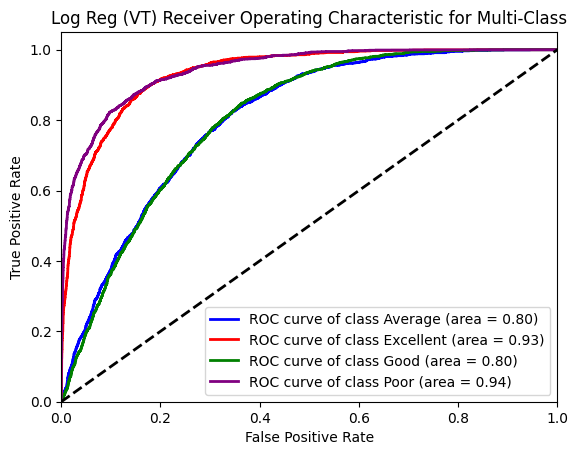

In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Use the y_test_binarized we created earlier
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score_logreg_vt[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure()
colors = cycle(['blue', 'red', 'green', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Log Reg (VT) Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()

#### ROC Curve Insights

**Logistic Regression (VT) ROC Summary**:

- **Excellent class**: The AUC score is 0.93, indicating the model has a high ability to differentiate between 'Excellent' movies and the other classes, and this performance is consistent with the previous model.
- **Poor class**: With an AUC score of 0.94, the model demonstrates an excellent capability in identifying movies in the 'Poor' category. This score is on par with the previous logistic regression model.
- **Average class**: The AUC score is 0.80. Although the model's performance is reasonably good, there's a slight drop in its ability to distinguish 'Average' movies when compared to the previous logistic regression model (which had an AUC of 0.81).
- **Good class**: The AUC score is 0.80, mirroring the model's performance with the 'Average' category and is consistent with the previous model's performance.

**Comparison with Previous Logistic Regression (without VT)**:

- The performance of the model on the 'Excellent' and 'Poor' classes remains consistent with AUC scores of 0.93 and 0.94, respectively, for both the current model with variance threshold (VT) and the previous one without VT.
- For the 'Average' and 'Good' classes, the AUC scores remain almost consistent. The only difference is a slight decrease of 0.01 in the AUC for the 'Average' class when using the variance threshold.
- In summary, applying a variance threshold (VT) to the logistic regression model has kept the performance relatively consistent, with only a minor decline for the 'Average' category.

Overall, both models offer good predictive capabilities across the classes, with the 'Excellent' and 'Poor' classes standing out in performance. The minor difference in the 'Average' class's AUC could be attributed to the variance thresholding, but the change is minimal.

### Classification Report

In [25]:
from sklearn.metrics import classification_report

# Generate classification report
logreg_vt_report = classification_report(y_test, y_pred_logreg_vt, target_names=class_labels, output_dict=True)

# Convert the classification report to a dataframe
logreg_vt_report_df = pd.DataFrame(logreg_vt_report).transpose()

In [26]:
# Show classificaiton report dataframe
logreg_vt_report_df

,precision,recall,f1-score,support
Average,0.527382,0.507109,0.517047,1899.000000
Excellent,0.734706,0.729285,0.731985,1762.000000
Good,0.532908,0.547980,0.540339,1980.000000
Poor,0.765926,0.777444,0.771642,1995.000000
accuracy,0.639602,0.639602,0.639602,0.639602
macro avg,0.640230,0.640454,0.640253,7636.000000
weighted avg,0.638977,0.639602,0.639199,7636.000000


#### Summary of Logistic Regression with Variance Threshold:
Utilizing variance threshold for feature selection in our logistic regression model yielded the following results:

- **Accuracy**: 63.96%
- **Average**:
  - Precision: 52.74%
  - Recall: 50.71%
  - F1-Score: 51.70%
- **Excellent**:
  - Precision: 73.47%
  - Recall: 72.93%
  - F1-Score: 73.20%
- **Good**:
  - Precision: 53.29%
  - Recall: 54.80%
  - F1-Score: 54.03%
- **Poor**:
  - Precision: 76.59%
  - Recall: 77.74%
  - F1-Score: 77.16%

#### Comparison with Logistic Regression using SelectFromModel:
When comparing with results from logistic regression using SelectFromModel, we observe:

- A slight increase in accuracy (from 63.49% to 63.96%) when using variance threshold.
- For the 'Average' category, precision decreased slightly with variance threshold, but recall showed a minor improvement, leading to a drop in F1-Score.
- In the 'Excellent' category, both precision and recall increased with variance threshold, resulting in a higher F1-Score.
- For the 'Good' category, variance threshold led to a small increase in both precision and recall, and subsequently a rise in F1-Score.
- The 'Poor' category showed a minor decrease in precision with variance threshold, but recall remained almost unchanged, resulting in a slight drop in F1-Score.

**Conclusion**: The variance threshold approach showed marginally better overall accuracy compared to SelectFromModel. While improvements were observed in certain categories, there were also minor setbacks in others. 

### Confusion Matrix

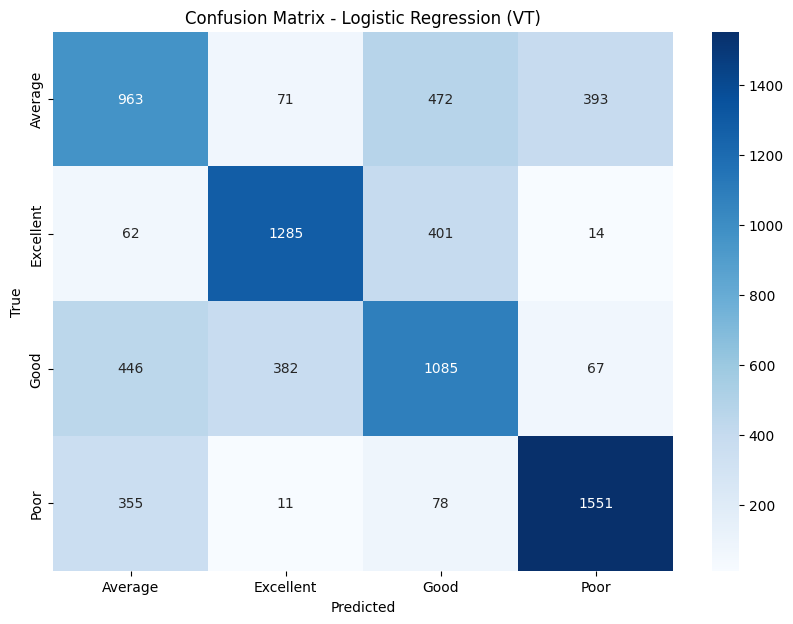

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate a confusion matrix for test and predicted labels
cm_logreg_vt = confusion_matrix(y_test, y_pred_logreg_vt)

# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_logreg_vt, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Logistic Regression (VT)')
plt.show()

**Logistic Regression (VT) Confusion Matrix Summary**:

- **"Average" Category Insights:**
  - 963 movies were correctly identified as "Average".
  - The model misclassified 472 movies as "Excellent" when they were actually "Average", which is a reduction compared to the previous results.
  - Other notable misclassifications include 71 movies that were predicted as "Excellent" and 393 as "Poor".<br>  
<br>
- **"Excellent" Category Insights:**
  - The model accurately classified 1285 movies as "Excellent", an increase from the previous results.
  - However, 401 movies were incorrectly labeled as "Good", which is a decrease in misclassifications from the prior model.
  - Lesser misclassifications include 62 movies predicted as "Average" and 14 as "Poor".<br>  
<br>
- **"Good" Category Insights:**
  - 1085 movies were correctly classified as "Good", showing an increase in accuracy from the previous model.
  - Misclassifications consist of 446 movies identified as "Average" and 67 as "Poor", which is an increase and decrease respectively when compared to the prior results.<br>  
<br>
- **"Poor" Category Insights:**
  - The model effectively identified 1551 movies as "Poor", which is consistent with the previous results.
  - There's a decrease in misclassifications with 355 "Poor" movies mislabeled as "Average" and an increase with 78 predicted as "Good".<br>  
<br>

**Comparison with Previous Results**:
- The new model with VT shows an improvement in the classification of the "Excellent" and "Good" categories.
- For the "Average" category, misclassifications as "Excellent" have reduced, while misclassifications as "Poor" have increased.
- "Poor" movies misclassified as "Average" have reduced, but there's a slight increase in misclassifications as "Good".
- As with the previous model, misclassifications predominantly occur between adjacent categories, but there's a general improvement with fewer misclassifications for some pairs.
- Misclassifications between "Excellent" and "Poor" remain uncommon, which is consistent with the earlier model.

To summarize, the Logistic Regression model with VT has shown improvements in certain classifications while maintaining a consistent performance in others. Most notably, it better classifies "Excellent" and "Good" movies with fewer misclassifications between these categories.

[Back to Top](#toc)

---

## Random Forest <a name="random-forest"></a>

### Why Choose Random Forest?

Random Forest combines multiple decision trees to create a more robust and accurate model, is well-suited for high-dimensional data, and can handle a mix of numerical and categorical features.

#### Chosen Hyperparameters

1. **`feature_selection__threshold`: [None, "mean"]**  
   - We use `SelectFromModel` for feature selection. The threshold is set to either `None` (no threshold, keep all features) or based on the mean feature importance across all trees.
    - `VarianceThrshold` for feature seletion. The thresholds are 0.0005 and 0.0009, based on previous baseline modeling results.<br>  
<br> 
2. **`classification__n_estimators`: [50, 100]**  
   - Number of trees in the forest. More trees increase robustness but also computational cost.<br>  
<br> 
3. **`classification__max_depth`: [None, 10, 20]**  
   - The maximum depth of each decision tree. A smaller depth can help prevent overfitting.<br>  
<br> 
4. **`classification__min_samples_split`: [2, 5]**  
   - The minimum number of samples required to split an internal node. Higher values prevent a model from learning relations which might be highly specific to the training data.<br>  
<br> 
5. **`classification__min_samples_leaf`: [1, 2]**  
   - The minimum number of samples required to be at a leaf node. Leaf nodes with a small sample size tend to capture noise in train data.<br>  
<br> 
6. **`classification__max_features`: ['auto', 'sqrt']**  
   - The number of features to consider when looking for the best split. 'Auto' uses all features whereas 'sqrt' uses the square root of the number of features.
   
These hyperparameters are chosen to provide a balance between model complexity and computational efficiency, and to mitigate overfitting.

### Pipeline & GridSearch

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create pipeline
rf_pipeline = Pipeline([
    ('feature_selection', SelectFromModel(RandomForestClassifier())),
    ('classification', rf_classifier)
])

In [ ]:
param_grid_rf = {
    'feature_selection__threshold': [None, "mean"],
    'classification__n_estimators': [50, 100],
    'classification__max_depth': [None, 10, 20],
    'classification__min_samples_split': [2, 5],
    'classification__min_samples_leaf': [1, 2],
    'classification__max_features': ['auto', 'sqrt']
}

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create the GridSearchCV object for Random Forest
grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, n_jobs=-1, verbose=1, error_score='raise')

# Fit it to the data
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('feature_selection',
                                        SelectFromModel(estimator=RandomForestClassifier())),
                                       ('classification',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classification__max_depth': [None, 10, 20],
                         'classification__max_features': ['auto', 'sqrt'],
                         'classification__min_samples_leaf': [1, 2],
                         'classification__min_samples_split': [2, 5],
                         'classification__n_estimators': [50, 100],
                         'feature_selection__threshold': [None, 'mean']},
             verbose=1)

Saving the trained model:

In [36]:
import joblib

# Save the trained model
joblib.dump(grid_search_rf.best_estimator_, '/content/drive/MyDrive/data/rf_model.pkl')

['/content/drive/MyDrive/data/rf_model.pkl']

### Best Params, Results & Summary

Getting results:

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize

# Get class labels from the trained model
class_labels = grid_search_rf.best_estimator_.named_steps['classification'].classes_

# Binarize y_test
y_test_binarized = label_binarize(y_test, classes=class_labels)

# Predict on the test set
y_pred_rf = grid_search_rf.best_estimator_.predict(X_test)
y_score_rf = grid_search_rf.best_estimator_.predict_proba(X_test)

In [29]:
# Execute the function and store the results
results_rf = post_grid_search_analysis(grid_search_rf, X_test, y_test)

# Print the results
print(f"Random Forest Best Parameters: {results_rf['Best Parameters']}")
print(f"Random Forest Best Score: {results_rf['Best Score']}")
print(f"Random Forest Test Accuracy: {results_rf['Test Accuracy']}")

Random Forest Best Parameters: {'classification__max_depth': 20, 'classification__max_features': 'sqrt', 'classification__min_samples_leaf': 2, 'classification__min_samples_split': 2, 'classification__n_estimators': 100, 'feature_selection__threshold': 'mean'}
Random Forest Best Score: 0.6155810147299509
Random Forest Test Accuracy: 0.6215295966474594


#### Random Forest Model Summary:

After conducting hyperparameter tuning, the optimal parameters for the Random Forest classifier were identified as:
- Max Depth: 20
- Max Features: 'sqrt'
- Min Samples Leaf: 2
- Min Samples Split: 2
- Number of Estimators: 100
- Feature Selection Threshold: 'mean'

With these parameters, the model achieved a cross-validation score of 61.56% on the training data. Upon evaluation on the test set, the model demonstrated an accuracy of 62.15%.

### ROC Curve

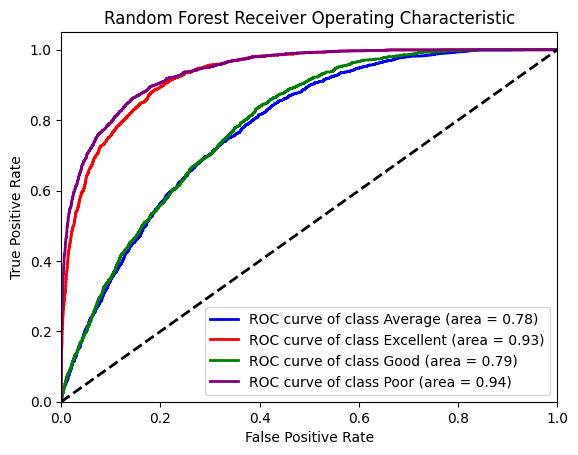

In [32]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Use the y_test_binarized we created earlier
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure()
colors = cycle(['blue', 'red', 'green', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### ROC Curve Insights - Random Forest

1. **Class Average**:
   - The area under the ROC curve (AUC) for the "Average" class is 0.78. This indicates good discrimination ability but leaves room for improvement.<br>
<br>
2. **Class Excellent**:
   - With an AUC of 0.93 for the "Excellent" class, the Random Forest model exhibits excellent discrimination ability for this category.<br>
<br>
3. **Class Good**:
   - The "Good" class has an AUC of 0.79, similar to the "Average" class. This means the model has a good ability to distinguish between positive and negative instances for the "Good" class.<br>
<br>
4. **Class Poor**:
   - The "Poor" class boasts the highest AUC of 0.94, showcasing outstanding discrimination ability for this category.

**Summary**:
- The Random Forest model demonstrates the strongest performance in distinguishing the "Poor" and "Excellent" classes, as seen by their high AUC values.
- While the model performs well for the "Average" and "Good" classes, there's room for improvement in these categories.
- Overall, the model has a strong ability to differentiate between positive and negative instances across all classes, with particular strength in the "Poor" and "Excellent" categories.

### Classification Report

In [33]:
from sklearn.metrics import classification_report

# Generate classification report
rf_report = classification_report(y_test, y_pred_rf, target_names=class_labels, output_dict=True)

# Convert the classification report to a dataframe
rf_report_df = pd.DataFrame(rf_report).transpose()

In [34]:
# Show classificaiton report dataframe
rf_report_df

,precision,recall,f1-score,support
Average,0.495982,0.454976,0.474595,1899.00000
Excellent,0.744411,0.699205,0.721100,1762.00000
Good,0.515820,0.543434,0.529267,1980.00000
Poor,0.731073,0.788972,0.758920,1995.00000
accuracy,0.621530,0.621530,0.621530,0.62153
macro avg,0.621821,0.621647,0.620971,7636.00000
weighted avg,0.619871,0.621530,0.619936,7636.00000


**Random Forest Performance Analysis:**

1. **Excellent Movies**:
    - **Precision**: 74.44% of movies predicted as 'Excellent' were accurately classified as such.
    - **Recall**: The model correctly identified 69.92% of the actual 'Excellent' movies in the dataset.
    - **F1-Score**: An F1-Score of 72.11% indicates a solid balance between precision and recall for the 'Excellent' category.
<br><br>
2. **Poor Movies**:
    - **Precision**: A notable 73.11% of movies forecasted as 'Poor' were correctly identified.
    - **Recall**: Among the genuine 'Poor' movies, the model successfully recognized 78.90%.
    - **F1-Score**: With an F1-Score of 75.89%, the model shows balanced accuracy for the 'Poor' movies.
<br><br>
3. **Average Movies**:
    - **Precision**: The model had a somehwat low precision of 49.60% for the 'Average' movies.
    - **Recall**: Out of all the films tagged as 'Average', the model correctly predicted 45.50%.
    - **F1-Score**: With an F1-Score of 47.46% for 'Average' movies, the model has balanced performance between precision and recall.
<br><br>
4. **Good Movies**:
    - **Precision**: Of the movies predicted as 'Good', 51.58% were accurate.
    - **Recall**: For the actual 'Good' movies, the model accurately classified 54.34% of them.
    - **F1-Score**: With F1-Score of 52.93%, the model shows an even performance for 'Good' movies.
<br><br>
5. **Overall Performance**:
    - The model had an **accuracy** of 62.15%, meaning it correctly predicted movie ratings for approximately 62 out of every 100 movies.
    - The **macro average** and **weighted average** metrics hover around the 62.1% mark, showing a consistent performance across various rating classes.

### Confusion Matrix

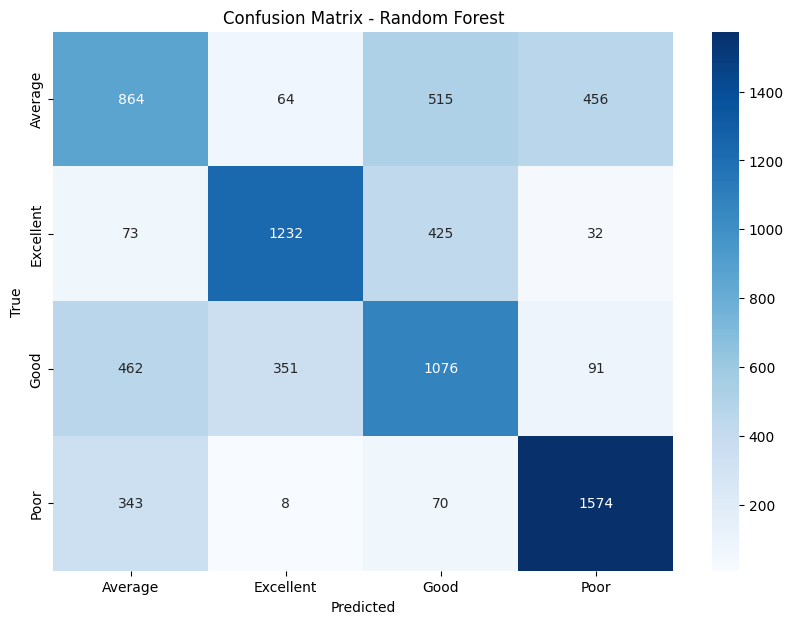

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate a confusion matrix for test and predicted labels
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest')
plt.show()

#### Confusion Matrix Summary 

1. **True Average Class**:
   - Most of the true "Average" class predictions are correctly classified as "Average" with 864 instances.
   - However, the model seems to be confused between "Average" and "Poor", wrongly classifying 456 true "Average" instances as "Poor".
   - There are smaller misclassifications into "Excellent" (64 instances) and "Good" (515 instances).
<br><br>
2. **True Excellent Class**:
   - The model performs relatively well for the "Excellent" class, correctly predicting 1232 instances as "Excellent".
   - Misclassifications for this class are predominantly into the "Good" class with 425 instances, while fewer instances are misclassified as "Average" (73) and "Poor" (32).
<br><br>
3. **True Good Class**:
   - The true "Good" instances are mostly correctly classified with 1076 instances.
   - However, a significant number of them are misclassified as "Average" (462 instances) and "Excellent" (351 instances). 
   - Only a smaller portion is wrongly predicted as "Poor" (91 instances).<br>
<br>
4. **True Poor Class**:
   - The classifier seems to excel in predicting the "Poor" class, with a high 1574 correct predictions.
   - Some confusion is apparent with the "Average" class, as 343 true "Poor" instances are misclassified as "Average".
   - Misclassifications into the other two categories ("Excellent" and "Good") are minimal with 8 and 70 instances, respectively.
<br><br>
In summary, the Random Forest model seems to perform best for the "Excellent" and "Poor" classes. The main area of confusion appears to be between the "Average" and "Good" classes, where the model seems to have a higher rate of misclassification.

[Back to Top](#toc)

---

## Random Forest - Variance Threshold <a name="random-forest---variance-threshold"></a>

Now, we'll run Random Forest with VarianceThreshold for feature selection and the same hyperparameters.

### Pipeline & ParamGrid

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create pipeline
rf_pipeline = Pipeline([
    ('variance_threshold', VarianceThreshold()),
    ('classification', rf_classifier)
])

In [11]:
param_grid_rf = {
    'variance_threshold__threshold': [0.0005, 0.0009],
    'classification__n_estimators': [50, 100],
    'classification__max_depth': [None, 10, 20],
    'classification__min_samples_split': [2, 5],
    'classification__min_samples_leaf': [1, 2],
    'classification__max_features': ['auto', 'sqrt']
}

In [12]:
from sklearn.model_selection import GridSearchCV

# Create the GridSearchCV object for Random Forest
grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, n_jobs=-1, verbose=1, error_score='raise')

# Fit it to the data
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('variance_threshold',
                                        VarianceThreshold()),
                                       ('classification',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classification__max_depth': [None, 10, 20],
                         'classification__max_features': ['auto', 'sqrt'],
                         'classification__min_samples_leaf': [1, 2],
                         'classification__min_samples_split': [2, 5],
                         'classification__n_estimators': [50, 100],
                         'variance_threshold__threshold': [0.0005, 0.0009]},
             verbose=1)

### Best Params, Results & Summary

Getting results:

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize

# Get class labels from the trained model
class_labels = grid_search_rf.best_estimator_.named_steps['classification'].classes_

# Binarize y_test
y_test_binarized = label_binarize(y_test, classes=class_labels)

# Predict on the test set
y_pred_rf_vt = grid_search_rf.best_estimator_.predict(X_test)
y_score_rf_vt = grid_search_rf.best_estimator_.predict_proba(X_test)

In [27]:
# Execute the function and store the results
results_rf_vt = post_grid_search_analysis(grid_search_rf, X_test, y_test)

# Print the results
print(f"Random Forest (Variance Threshold) Best Parameters: {results_rf_vt['Best Parameters']}")
print(f"Random Forest (Variance Threshold) Best Score: {results_rf_vt['Best Score']}")
print(f"Random Forest (Variance Threshold) Test Accuracy: {results_rf_vt['Test Accuracy']}")


Random Forest (Variance Threshold) Best Parameters: {'classification__max_depth': None, 'classification__max_features': 'auto', 'classification__min_samples_leaf': 2, 'classification__min_samples_split': 2, 'classification__n_estimators': 100, 'variance_threshold__threshold': 0.0009}
Random Forest (Variance Threshold) Best Score: 0.6119148936170212
Random Forest (Variance Threshold) Test Accuracy: 0.6225772655840754


Saving trained model: 

In [33]:
import joblib

# Save the trained model
joblib.dump(grid_search_rf.best_estimator_, '/content/drive/MyDrive/data/rf_vt_model.pkl')

['/content/drive/MyDrive/data/rf_vt_model.pkl']

#### Summary Random Forest Model Results

We used a Random Forest classifier with a pipeline that includes variance thresholding for feature selection. single decision tree.

#### Hyperparameters
The hyperparameters were tuned using GridSearchCV, and the best parameters are as follows:
- Maximum Depth of Trees: None (unlimited depth, capturing more complex patterns)
- Number of Trees: 100
- Minimum Samples for Splitting: 2
- Minimum Samples per Leaf: 2
- Maximum Features: 'auto' (sqrt(n_features))
- Variance Threshold: 0.0009 (for feature selection)

#### Model Performance
- Best Score (Cross-Validation): 0.612
- Test Accuracy: 0.623

The model achieved a test accuracy close to the best cross-validated score, indicating that the model generalizes well to unseen data. The variance threshold of 0.0009 helped in eliminating features that are constant or near-constant, thereby potentially improving model performance.

### ROC Curve

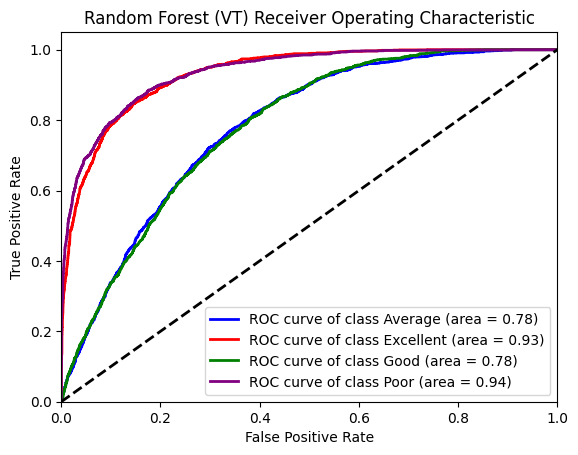

In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Use the y_test_binarized we created earlier
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score_rf_vt[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure()
colors = cycle(['blue', 'red', 'green', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest (VT) Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**Random Forest with Variance Threshold (VT) ROC Summary**:

1. **Class Average**:
   - The AUC for the "Average" class remains unchanged at 0.78, indicating the discrimination ability for this class did not improve with the variance threshold.<br>
<br>
2. **Class Excellent**:
   - The AUC for the "Excellent" class is consistent at 0.93, maintaining its strong discrimination performance.<br>
<br>
3. **Class Good**:
   - The "Good" class AUC is also consistent at 0.78, showing that the variance threshold had no effect on improving this class's performance.<br>
<br>
4. **Class Poor**:
   - The AUC for the "Poor" class is still at a high of 0.94, exhibiting no change in discrimination ability.
   
**Contrast with Previous Random Forest without VT**:
- **Overall Performance**: The ROC curves and AUC values for both models (with and without VT) are nearly identical. This suggests that the variance threshold did not significantly impact the model's ability to discriminate between the classes.
- **Specific Classes**: For all classes ("Average," "Excellent," "Good," and "Poor"), the AUC values remain unchanged between the two models. 
- Applying the variance threshold in this instance did not enhance or diminish the Random Forest model's performance. This might imply that the features removed by the variance threshold were not influential in the model's decision-making process for these particular classes.

### Classification Report

In [29]:
from sklearn.metrics import classification_report

# Generate classification report
rf_vt_report = classification_report(y_test, y_pred_rf_vt, target_names=class_labels, output_dict=True)

# Convert the classification report to a dataframe
rf_vt_report_df = pd.DataFrame(rf_vt_report).transpose()

In [30]:
# Show classification report df
rf_vt_report_df

,precision,recall,f1-score,support
Average,0.505196,0.460769,0.481961,1899.000000
Excellent,0.738235,0.712259,0.725014,1762.000000
Good,0.512445,0.530303,0.521221,1980.000000
Poor,0.730394,0.788972,0.758554,1995.000000
accuracy,0.622577,0.622577,0.622577,0.622577
macro avg,0.621568,0.623076,0.621688,7636.000000
weighted avg,0.619685,0.622577,0.620489,7636.000000


**Random Forest with Variance Threshold Performance Analysis:**

1. **Excellent Movies**:
    - **Precision**: 73.82% of movies predicted as 'Excellent' were correctly identified.
    - **Recall**: Of the genuine 'Excellent' movies, the model successfully predicted 71.23%.
    - **F1-Score**: The F1-Score of 72.50% reflects a good balance between precision and recall.<br>
<br>
2. **Poor Movies**:
    - **Precision**: 73.04% of the movies projected as 'Poor' were correctly classified.
    - **Recall**: The model captured a significant 78.90% of actual 'Poor' movies.
    - **F1-Score**: With an F1-Score of 75.86%, the model maintains strong precision-recall harmony for the 'Poor' category.<br>
<br>
3. **Average Movies**:
    - **Precision**: 50.52% accuracy was noted for 'Average' movie predictions.
    - **Recall**: The model successfully picked up 46.08% of the actual 'Average' films.
    - **F1-Score**: With an F1-score of 48.20%, the model has a midpoint balance for this category.<br>
<br>
4. **Good Movies**:
    - **Precision**: For 'Good' movies, the precision stands at 51.24%.
    - **Recall**: The model correctly identified 53.03% of genuine 'Good' movies.
    - **F1-Score**: An F1-Score of 52.12% shows a balanced model performance for 'Good' movies.<br>
<br>
5. **Overall Performance**:
    - The model has an **accuracy** of 62.26%, meaning it correctly predicted movie ratings for just over 62 out of every 100 movies.
    - Both the **macro average** and **weighted average** metrics are slightly above the 62% mark, ensuring consistency.<br>
<br>

**Comparison with Previous Random Forest Model**:

- Both models have almost similar performance for the 'Excellent' and 'Poor' categories, but the Random Forest with variance threshold shows a slight improvement in recall for 'Excellent' movies.
- For 'Average' movies, the model with variance threshold has increased precision by approximately 1% compared to the previous model. The recall also sees a slight rise.
- The performance for 'Good' movies remains relatively stable in both models, with negligible differences.
- The overall accuracy is slightly higher (by a mere 0.1%) in the model with variance threshold. This indicates that the variance thresholding had a subtle positive impact on the model's performance.

In summary, the application of variance thresholding to Random Forest appears to provide a minor enhancement in prediction accuracy across the board, but particularly for 'Excellent' and 'Average' movies.

### Confusion Matrix

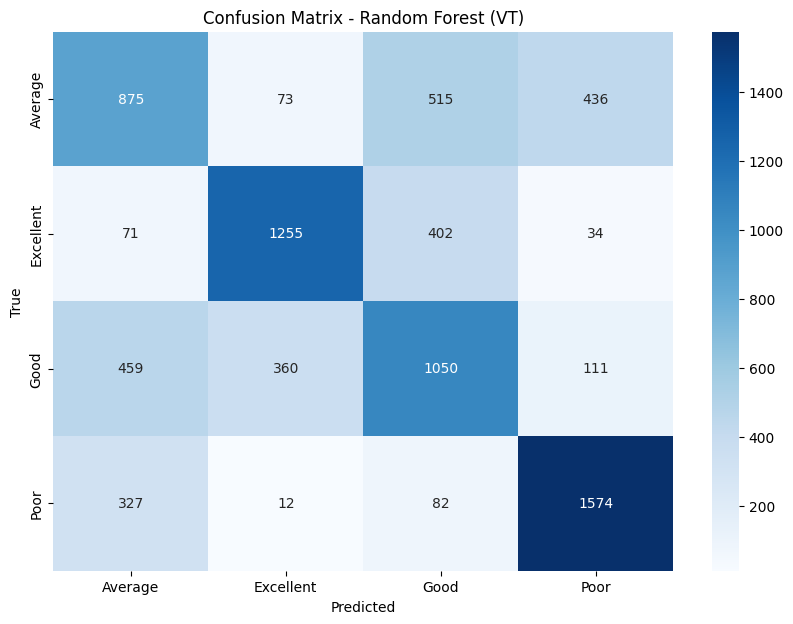

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate a confusion matrix for test and predicted labels
cm_rf_vt = confusion_matrix(y_test, y_pred_rf_vt)

# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf_vt, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest (VT)')
plt.show()

**Confusion Matrix - Random Forest with Variance Threshold (VT):**

1. **True Average Class**:
   - The majority of true "Average" predictions are accurate with 875 instances.
   - The most notable misclassification is with the "Poor" category at 436 instances.
   - Other misclassifications are into "Excellent" (73 instances) and "Good" (515 instances).<br>
<br>
2. **True Excellent Class**:
   - A total of 1255 "Excellent" instances are correctly predicted.
   - The most common misclassification is into the "Good" class, totaling 402 instances.
   - Misclassifications into the other two categories, "Average" and "Poor", are at 71 and 34 instances, respectively.<br>
<br>
3. **True Good Class**:
   - This model accurately classifies 1050 true "Good" instances.
   - It misclassifies a significant number into "Average" (459 instances) and "Excellent" (360 instances).
   - Misclassification into "Poor" is smaller at 111 instances.<br>
<br>
4. **True Poor Class**:
   - This version of the model remains strong in classifying the "Poor" category, getting 1574 instances correct.
   - The "Average" category sees a misclassification of 327 instances.
   - Other categories see minor misclassifications: "Excellent" at 12 and "Good" at 82 instances.
<br>
<br>

**Contrast to the previous Random Forest model:**

1. **True Average Class**:
   - The VT model improves slightly in correctly classifying "Average" instances (from 864 to 875).
   - Misclassification into the "Poor" category is lower with the VT model (from 456 down to 436).
<br>
<br>
2. **True Excellent Class**:
   - The VT model has a minor improvement in accurate predictions (from 1232 to 1255).
   - However, misclassifications into the "Good" class have decreased slightly (from 425 to 402).
<br>
<br>
3. **True Good Class**:
   - Accurate classifications have decreased slightly in the VT model (from 1076 to 1050).
   - Misclassifications into the "Average" category have also decreased slightly (from 462 to 459).
<br>
<br>
4. **True Poor Class**:
   - Both models perform similarly with a strong accuracy in the "Poor" category (both at 1574 correct predictions).
   - Misclassifications into the "Average" category are slightly worse in the VT model (from 343 to 327).

In summary, the Random Forest model with Variance Threshold (VT) exhibits minor improvements in classification accuracy for the "Average" and "Excellent" classes when compared to the original Random Forest model. The "Good" class saw a slight decrease in accurate predictions with the VT model. Both models perform exceptionally well for the "Poor" class. Overall, the differences between the two models are marginal, suggesting that the Variance Thresholding had only a minor effect on the classifier's performance.

[Back to Top](#toc)

---

## XGBoost - Variance Threshold <a name="xgboost---variance-threshold"></a>

In our exploration of optimizing the XGBoost model, we decided to focus exclusively on the Variance Threshold (VT) method for feature selection. XGBoost when paired with SelectFromModel, had an extended runtime, taking up to 15 hours without convergence. Given the previously observed performance of other models, where the difference in efficacy between using and not using the Variance Threshold was minimal, we concluded that we are unlikely to be sacrificing significant performance gains by forgoing the SelectFromModel for feature selection. This decision allowed us to maintain a balance between computational efficiency and model performance.

### Why Choose XGBoost?

XGBoost has a lot of popularity due to its high performance and versatility. It can handle a variety of data types, including high-dimensional data, and is less prone to overfitting. It's especially useful for imbalanced datasets and can also provide feature importance scores.

### Rationale Behind Hyperparameters

1. **`VarianceThreshold`: [None, "mean"]**  
   - As with other models, `VarianceThreshold` is used for feature selection with thresholds of 0.0005 and 0.0009.<br>
<br>
2. **`classification__n_estimators`: [30, 50]**  
   - Number of boosting rounds to be run. More rounds can result in better performance but may lead to overfitting.<br>
<br>
3. **`classification__learning_rate`: [0.05, 0.1]**  
   - Step size to prevent overfitting.<br>
<br>
4. **`classification__max_depth`: [2, 3]**  
   - Maximum depth of a tree. Lower values can prevent overfitting.<br>
<br>
5. **`classification__min_child_weight`: [2, 3]**  
   - Minimum sum of instance weight needed in a child node. Higher values can control overfitting.<br>
<br>
6. **`classification__subsample`: [0.7, 0.8]**  
   - Proportion of training data to randomly sample in each boosting round. Helps in preventing overfitting.<br>
<br>
7. **`classification__colsample_bytree`: [0.7, 0.8]**  
   - Fraction of features to choose for each boosting round. This is another way to control overfitting.<br>
<br>

These hyperparameters are chosen to balance model performance and computational efficiency, and to help prevent overfitting.

### Pipeline & Param Grid

In [7]:
# Import
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold


XGBoost expects numeric labels, so we will encode our y train variable.

In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

In [8]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

# Initialize XGBoost classifier
xgb_classifier = XGBClassifier(objective='multi:softmax', num_class=4, seed=42)

# Create pipeline
xgb_pipeline = Pipeline([
    ('variance_threshold', VarianceThreshold()),
    ('classification', xgb_classifier)
])

In [9]:
# Define param grid
param_grid_xgb = {
    'variance_threshold__threshold': [0.0005, 0.0009],
    'classification__n_estimators': [30, 50],
    'classification__learning_rate': [0.05, 0.1],
    'classification__max_depth': [2, 3],
    'classification__min_child_weight': [2, 3],
    'classification__subsample': [0.7, 0.8],
    'classification__colsample_bytree': [0.7, 0.8]
}

In [14]:
# Create the GridSearchCV object
grid_search_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=5, n_jobs=-1, verbose=2, error_score='raise')

# Fit it to the data
grid_search_xgb.fit(X_train, y_train_encoded)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('variance_threshold',
                                        VarianceThreshold()),
                                       ('classification',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,...
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'classification__colsample_bytree': [0.7, 0.8],
                         'classification__learning_rate': [0.05, 0.1],
                         'classification__max_depth': [2, 3],
                         'classification__min_child_weight': [2, 3],
                         'classification__n_estimators': [30, 50],
                         'classification__subsample': [0.7, 0.8],
                         'variance_threshold__threshold': [0.0005, 0.0009]},
             verbose=2)

Saving trained model:

In [58]:
import joblib

# Save the trained model
joblib.dump(grid_search_xgb.best_estimator_, '/content/drive/MyDrive/data/xgboost_vt_model.pkl')

['/content/drive/MyDrive/data/xgboost_vt_model.pkl']

### Best Params, Results & Summary

Getting the results:

In [27]:
# Encode y_test
y_test_encoded = le.transform(y_test)

In [49]:
# Predict on the test set
y_pred_xgb_vt = grid_search_xgb.best_estimator_.predict(X_test)
y_score_xgb_vt = grid_search_xgb.best_estimator_.predict_proba(X_test)

In [50]:
# Execute the function and store the results
results_xgb_vt = post_grid_search_analysis(grid_search_xgb, X_test, y_test_encoded)

# Print the results
print(f"XGBoost (Variance Threshold) Best Parameters: {results_xgb_vt['Best Parameters']}")
print(f"XGBoost (Variance Threshold) Best Score: {results_xgb_vt['Best Score']}")
print(f"XGBoost Forest (Variance Threshold) Test Accuracy: {results_xgb_vt['Test Accuracy']}")

XGBoost (Variance Threshold) Best Parameters: {'classification__colsample_bytree': 0.7, 'classification__learning_rate': 0.1, 'classification__max_depth': 3, 'classification__min_child_weight': 3, 'classification__n_estimators': 50, 'classification__subsample': 0.7, 'variance_threshold__threshold': 0.0005}
XGBoost (Variance Threshold) Best Score: 0.6019312602291326
XGBoost Forest (Variance Threshold) Test Accuracy: 0.6094814038763751


#### XGBoost Model Summary

**Model Configuration:**
- **Feature Selection:** Variance Threshold with a threshold value of 0.0005.
- **Classifier:** XGBoost with parameters optimized through grid search.
- **Hyperparameters:**
    - `colsample_bytree`: 0.7
    - `learning_rate`: 0.1
    - `max_depth`: 3
    - `min_child_weight`: 3
    - `n_estimators`: 50
    - `subsample`: 0.7

**Performance Metrics:**
- **Best Training Score (Cross-Validation):** 0.602
- **Test Accuracy:** 0.609

**Interpretation:**
The optimized XGBoost model achieved a training accuracy of approximately 60.2% during cross-validation and a test accuracy of 60.9%. The model used a variance threshold of 0.0005 for feature selection. Overall, the model provides a reasonable but not outstanding performance on the dataset.

### ROC Curve

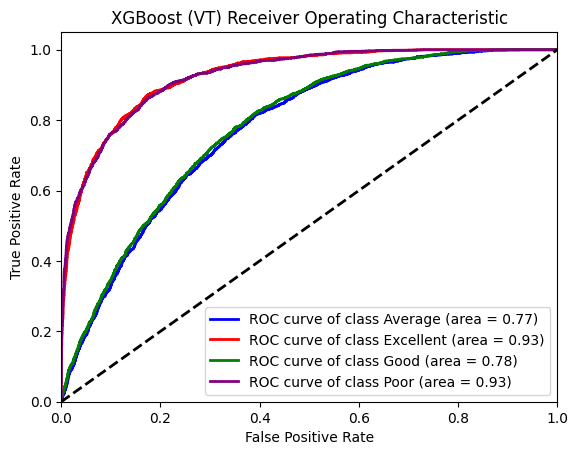

In [51]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# The number of unique classes
n_classes = len(np.unique(y_test_encoded))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_encoded == i, y_score_xgb_vt[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure()
colors = cycle(['blue', 'red', 'green', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost (VT) Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


**XGBoost with Variance Threshold (VT) ROC Summary**:   

1. **Class Average**:
   - AUC = 0.77. This indicates a reasonably good discrimination ability for distinguishing the "Average" class from the others.<br>
<br>
2. **Class Excellent**:
   - AUC = 0.93. The "Excellent" class exhibits a strong discrimination performance, similar to the Random Forest models we observed earlier.<br>
<br>
3. **Class Good**:
   - AUC = 0.78. This value represents a decent discrimination ability for the "Good" class.<br>
<br>
4. **Class Poor**:
   - AUC = 0.93. The model shows a high discrimination capability for the "Poor" class, consistent with our previous observations.

**Comparison with Previous Random Forest (with and without VT)**:
- **Overall Performance**: The AUC values for the XGBoost model are quite comparable to those of the Random Forest models (both with and without VT). This suggests that both modeling techniques have similar capabilities for this specific problem.

- **Class Specifics**:
   - **Average**: The XGBoost model has an AUC of 0.77 for the "Average" class, which is slightly lower than the Random Forest's 0.78.
   - **Excellent**: Both models have the same AUC value of 0.93, indicating equal discrimination ability for the "Excellent" class.
   - **Good**: The AUC values remain consistent at 0.78 for both models.
   - **Poor**: Both the XGBoost and Random Forest models exhibit an AUC of 0.93 for the "Poor" class, again indicating similar performances.

In summary, the XGBoost model with VT offers performance metrics closely aligned with the Random Forest models for the given classes. This implies that both algorithms can be effectively used for this classification task.

### Classification Report

In [52]:
from sklearn.metrics import classification_report

# Generate classification report
xbg_vt_report = classification_report(y_test_encoded, y_pred_xgb_vt, target_names=class_labels, output_dict=True)

# Convert the classification report to a dataframe
xbg_vt_report_df = pd.DataFrame(xbg_vt_report).transpose()

In [43]:
# Show classification report dataframe
xbg_vt_report_df

,precision,recall,f1-score,support
Average,0.505473,0.413375,0.454809,1899.000000
Excellent,0.713812,0.733258,0.723404,1762.000000
Good,0.492414,0.540909,0.515523,1980.000000
Poor,0.717827,0.754887,0.735891,1995.000000
accuracy,0.609481,0.609481,0.609481,0.609481
macro avg,0.607381,0.610607,0.607407,7636.000000
weighted avg,0.605641,0.609481,0.605966,7636.000000


**XGBoost with Variance Thresholding Performance Analysis:**

1. **Excellent Movies**:
    - **Precision**: 71.38% of movies predicted as 'Excellent' were actually 'Excellent'.
    - **Recall**: Of all the 'Excellent' movies in the test set, 73.32% were correctly identified by the model.
    - **F1-Score**: The harmonic mean of precision and recall for 'Excellent' movies is 72.34%, indicating a balanced performance.

2. **Poor Movies**:
    - **Precision**: 71.78% of movies predicted as 'Poor' were indeed 'Poor'.
    - **Recall**: The model correctly identified 75.49% of all 'Poor' movies in the test set.
    - **F1-Score**: The balanced performance for 'Poor' movies is reflected in an F1-Score of 73.59%.

3. **Average Movies**:
    - **Precision**: 50.55% of movies predicted as 'Average' were accurately labeled.
    - **Recall**: The model captured 41.34% of all 'Average' movies in the test set.
    - **F1-Score**: Given the lower precision and recall, the F1-Score for 'Average' movies is 45.48%.

4. **Good Movies**:
    - **Precision**: 49.24% of movies predicted as 'Good' were correctly classified.
    - **Recall**: Of all 'Good' movies, the model successfully identified 54.09%.
    - **F1-Score**: The F1-Score for 'Good' movies stands at 51.55%, reflecting the balance between precision and recall.

**Overall Performance**:
- The model achieved an **accuracy** of 60.95%, meaning it correctly predicted the rating class for approximately 61 out of every 100 movies.
- In terms of **macro average**, which gives equal weight to each class, the precision, recall, and F1-score hover around the 60% mark, suggesting consistent performance across all classes.
- The **weighted average** metrics, which account for class imbalances, closely mirror the macro averages, with precision, recall, and F1-scores all slightly above 60%.

### Confusion Matrix

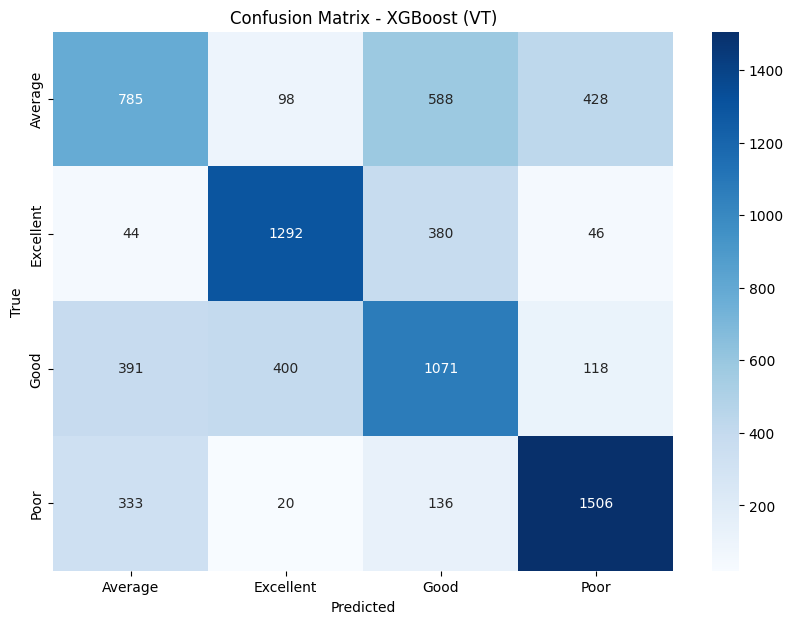

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate a confusion matrix for test and predicted labels
cm_xgb_vt = confusion_matrix(y_test_encoded, y_pred_xgb_vt)

# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_xgb_vt, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - XGBoost (VT)')
plt.show()


**Confusion Matrix - XGBoost (VT) Summary**:

1. **Class "Average"**:
   - **True Positives (TP)**: 785 instances were correctly predicted as "Average".
   - **False Negatives (FN)**: This class has been misclassified as "Excellent" 98 times, as "Good" 588 times, and as "Poor" 428 times.<br>
<br>
2. **Class "Excellent"**:
   - **TP**: 1292 instances were correctly predicted as "Excellent".
   - **FN**: 44 instances of "Excellent" were misclassified as "Average", 380 as "Good", and 46 as "Poor".<br>
<br>
3. **Class "Good"**:
   - **TP**: 1071 instances were correctly predicted as "Good".
   - **FN**: The model misclassified 391 instances of "Good" as "Average", 400 as "Excellent", and 118 as "Poor".<br>
<br>
4. **Class "Poor"**:
   - **TP**: 1506 instances were correctly identified as "Poor".
   - **FN**: 333 instances of "Poor" were mistaken for "Average", 20 for "Excellent", and 136 for "Good".

**Overall Insights**:
- The XGBoost model is doing a great job at classifying the "Poor" and "Excellent" classes, as evident from the high true positive counts.
- The model seems to be having the most difficulty with the "Average" and "Good" classes. Specifically, many "Average" instances are being misclassified as "Good" and vice-versa.
- Misclassifications between "Good" and "Average" might indicate that the features do not strongly distinguish between these two classes, or there might be overlap in the data representation of these classes.

**Comparison with Previous Models**:
- Generally speaking, the XGBoost model's performance for the "Poor" and "Excellent" classes seems to align closely with that of the previous models. The high true positive counts for these classes in both models emphasize their effectiveness.
- For the "Average" and "Good" classes, all models had challenges distinguishing between these two classes.

[Back to Top](#toc)

---

## Ensemble Learning <a name="ensemble-learning"></a>

In the final phase of our model building, we employed two ensemble methods: Voting Classifier and Stacking Classifier. Both techniques aim to improve the model's generalization ability and robustness by combining multiple models, but they differ in their approach and complexity. The Stacking Classifier often performs better but at the cost of higher computational expenses, while the Voting Classifier is simpler and faster but may not capture complex patterns as effectively as stacking.

To create the ensemble models, we will be using the previously saved pkl files of our trained individual models. We are using each of the models with VarianceThreshold, for consistency.

#### Constituent Models and their Test Accuracies:
As a reminder, these are the models and accuracies that we are working with: 
1. Logistic Regression: Approx. 63.5%
2. Random Forest: Approx. 62.3%
3. XGBoost: Approx. 60.9%

### Voting Classifier

We will use a Voting Classifier with a soft voting strategy, i.e. the class probabilities predicted by each model are averaged, and the final prediction based on the averaged probabilities. 

Loading the trained models that were previously saved:

In [8]:
import joblib

# Load the models
loaded_logistic_model = joblib.load('/content/drive/MyDrive/data/logreg_vt_model.pkl')
loaded_rf_model = joblib.load('/content/drive/MyDrive/data/rf_vt_model.pkl')
loaded_xgb_model = joblib.load('/content/drive/MyDrive/data/xgboost_vt_model.pkl')


In [11]:
# Double checking our models
test_score_logistic = loaded_logistic_model.score(X_test, y_test)
test_score_rf = loaded_rf_model.score(X_test, y_test)
test_score_xgb = loaded_xgb_model.score(X_test, y_test_encoded)

print(f'Logistic Regression Test Accuracy: {test_score_logistic}')
print(f'Random Forest Test Accuracy: {test_score_rf}')
print(f'XGBoost Test Accuracy: {test_score_xgb}')


Logistic Regression Test Accuracy: 0.639601885804086
Random Forest Test Accuracy: 0.6225772655840754
XGBoost Test Accuracy: 0.6094814038763751


Encoding y variables:

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

In [7]:
# Encode y_test
y_test_encoded = le.transform(y_test)

Creating ensemble voting classifier and evaluating on test set:

In [12]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV

# Initialize individual models with the loaded models
logistic_model = loaded_logistic_model
rf_model = loaded_rf_model
xgb_model = loaded_xgb_model

# Create an ensemble of the models using a majority class voting strategy
ensemble_model = VotingClassifier(estimators=[('lr', logistic_model), ('rf', rf_model), ('xgb', xgb_model)], voting='soft')

# Fit the ensemble model
ensemble_model.fit(X_train, y_train_encoded)

# Evaluate the ensemble on the test set
ensemble_score = ensemble_model.score(X_test, y_test_encoded)

print(f'Ensemble Test Accuracy: {ensemble_score}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Ensemble Test Accuracy: 0.6561026715557884


Makings predictions:

In [34]:
# Make predictions
y_pred_voting = ensemble_model.predict(X_test)
y_score_voting = ensemble_model.predict_proba(X_test)

# Getting class labels
class_labels = ensemble_model.classes_

#### Classification Report

Getting the classification report:

In [37]:
# Generate Classification Report

# Decode the  class labels
decoded_class_labels = le.inverse_transform([0, 1, 2, 3])

# classification report
print("Classification Report for Voting Classifier:")
print(classification_report(y_test_encoded, y_pred_voting, target_names=decoded_class_labels))

Classification Report for Voting Classifier:
              precision    recall  f1-score   support

     Average       0.56      0.50      0.52      1899
   Excellent       0.76      0.76      0.76      1762
        Good       0.55      0.58      0.56      1980
        Poor       0.76      0.79      0.78      1995

    accuracy                           0.66      7636
   macro avg       0.66      0.66      0.66      7636
weighted avg       0.65      0.66      0.65      7636



#### Confusion Matrix

Creating heatmap of confusion matrix: 

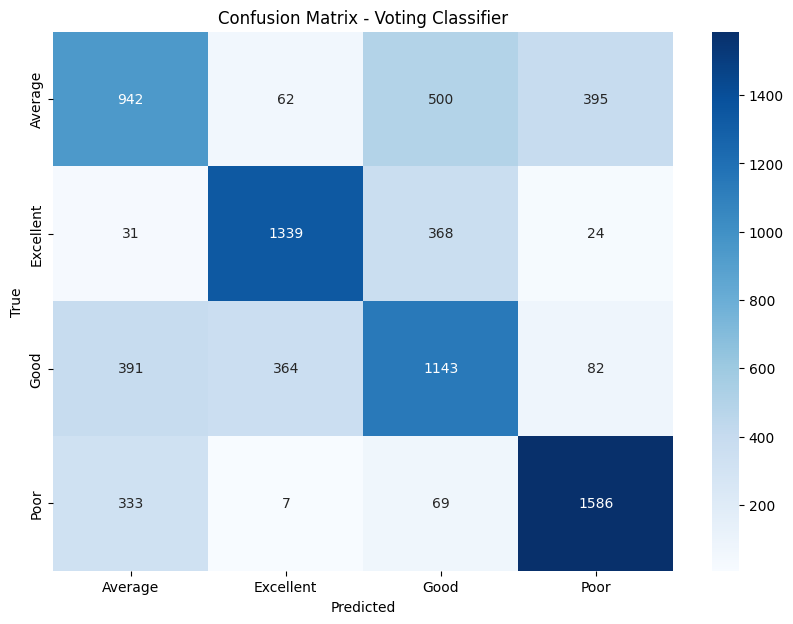

In [47]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm_voting = confusion_matrix(y_test_encoded, y_pred_voting)

# Using seaborn to make the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_voting, annot=True, fmt='g', cmap="Blues",
            xticklabels=decoded_class_labels, yticklabels=decoded_class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Voting Classifier')
plt.show()

#### Voting Classifier Test Accuracy:

The voting classifier achieved a test accuracy of approximately 65.6%, which is a slight improvement over some of the individual models. This suggests that our ensemble model is more robust and potentially offers a better generalization to new, unseen data.

---

### Stacking Classifier
Now we will use a Stacking Classifier with a Logistic Regression meta-model trained to make the most accurate predictions based on how well the base models perform.

In [1]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

Creating stacking classifier with loaded models:

In [12]:
# Initialize the Stacking Classifier with the individual models and a logistic regression meta-model
stacking_model = StackingClassifier(
    estimators=[('lr', loaded_logistic_model), ('rf', loaded_rf_model), ('xgb', loaded_xgb_model)],
    final_estimator=LogisticRegression()
)

# Fit the stacking classifier
stacking_model.fit(X_train, y_train_encoded)

# Evaluate the model
stacking_score = stacking_model.score(X_test, y_test_encoded)

print(f'Stacking Classifier Test Accuracy: {stacking_score}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Stacking Classifier Test Accuracy: 0.6616029334730226


Making predictions: 

In [22]:
# Make predictions
y_pred_stacking = stacking_model.predict(X_test)
y_score_stacking = stacking_model.predict_proba(X_test)

# Getting class labels
class_labels = stacking_model.classes_

#### Classification Report

Generate classification report:

In [31]:
# Generate Classification Report

# Decode the  class labels
decoded_class_labels = le.inverse_transform([0, 1, 2, 3])

# classification report
print("Classification Report for Stacking Classifier:")
print(classification_report(y_test_encoded, y_pred_stacking, target_names=decoded_class_labels))

Classification Report for Stacking Classifier:
              precision    recall  f1-score   support

     Average       0.54      0.56      0.55      1899
   Excellent       0.77      0.75      0.76      1762
        Good       0.55      0.58      0.57      1980
        Poor       0.80      0.76      0.78      1995

    accuracy                           0.66      7636
   macro avg       0.67      0.66      0.67      7636
weighted avg       0.67      0.66      0.66      7636



#### Confusion Matrix

Plot heatmap of confusion matrix:

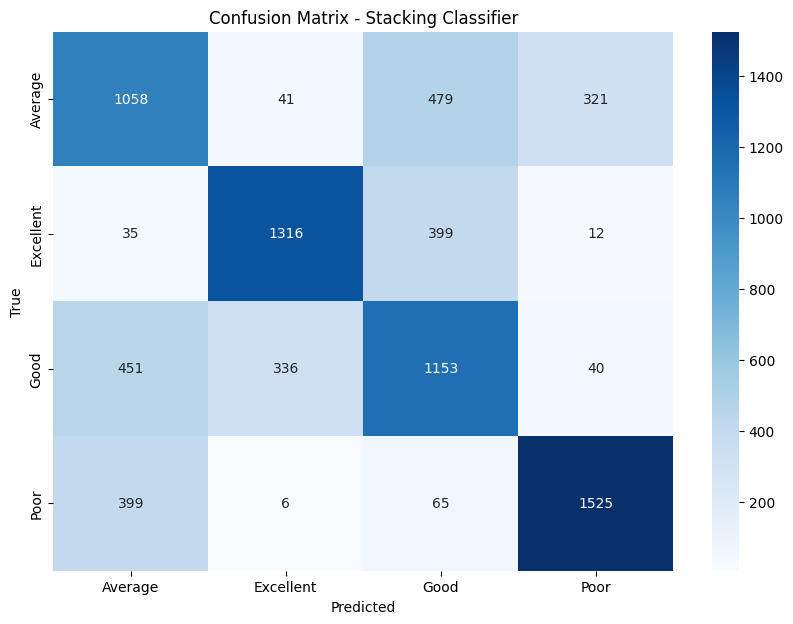

In [48]:
# Confusion Matrix
cm_stacking = confusion_matrix(y_test_encoded, y_pred_stacking)

# Using seaborn to make the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_stacking, annot=True, fmt='g', cmap="Blues",
            xticklabels=decoded_class_labels, yticklabels=decoded_class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Stacking Classifier')
plt.show()

#### Stacking Classifier Test Accuracy:

The stacking classifier didn't fully converge, but still achieved a test accuracy of approximately 66.1%, which is a slight improvement over both the individual models and the voting classifier.

[Back to Top](#toc)

---

### Summary & Comparison of Ensemble Learning Methods

- Both models have essentially the same overall accuracy of 0.66, higher than any of the individual models.
- The Stacking Classifier has a slightly better precision for the "Poor" category (0.80 vs. 0.76) compared to the Voting Classifier.
- The Voting Classifier marginally outperforms the Stacking Classifier in the "Average" category in terms of precision (0.56 vs. 0.54).
- Both models seem to struggle similarly with the "Average" and "Good" categories compared to the "Excellent" and "Poor" ones, similar to the rest of our models. 

---

## Error Analysis <a name="error-analysis"></a>

We can also perform additional error analysis to learn where the missclassifications are coming from. Here we'll take a look at the missclassifications from the trained Logistic Regression model.

In [13]:
# Identify indices of the missclassificaitons
misclassified_indices = np.where(y_pred_logreg != y_test_encoded)[0]

In [14]:
# Inspect features
misclassified_samples = X_test.iloc[misclassified_indices]

In [16]:
# Check actual vs predicted
actual_labels = y_test_encoded[misclassified_indices]
predicted_labels = y_pred_logreg[misclassified_indices]

In [21]:
# Decode y labels
decoded_predicted_labels = le.inverse_transform(y_test_encoded)

In [17]:
# Create dataframe with actual and predicted labels
misclassified_df = pd.DataFrame({
    'Actual': actual_labels,
    'Predicted': predicted_labels
})

In [23]:
# Decode labels
decoded_predicted_labels = le.inverse_transform(y_test_encoded)

# Add to dataframe
misclassified_df['Predicted_Decoded'] = decoded_predicted_labels

In [24]:
# Show missclassified dataframe
misclassified_df

,Actual,Predicted,Predicted_Decoded
0,2,Good,Good
1,3,Poor,Poor
2,0,Average,Average
3,0,Average,Average
4,0,Average,Average
...,...,...,...
7631,2,Excellent,Good
7632,2,Excellent,Good
7633,2,Average,Good
7634,3,Poor,Poor


In [27]:
# Extract the rows in X_test for misclassified samples
misclassified_samples = X_test.iloc[misclassified_indices]

# Sum to get the frequency of each feature
feature_sums = misclassified_samples.sum(axis=0)

# Sort to get the most common features
sorted_feature_sums = feature_sums.sort_values(ascending=False)

# Show the top 10 most frequent unigrams/features
print("Top 10 most frequent features in misclassified samples:")
print(sorted_feature_sums.head(20))

Top 10 most frequent features in misclassified samples:
language_en          5831.000000
genre_Drama          4120.000000
genre_Comedy         2443.000000
genre_Romance        1285.000000
genre_Action         1281.000000
genre_Crime          1270.000000
genre_Thriller       1001.000000
unigram_make          995.580326
genre_Horror          963.000000
unigram_good          943.283290
genre_Adventure       938.000000
unigram_time          727.503568
unigram_story         708.463377
unigram_character     707.180478
genre_Mystery         575.000000
unigram_great         560.436039
unigram_really        548.110402
unigram_scene         510.580939
unigram_think         493.689848
unigram_love          483.296195
dtype: float64


The results indicate that the most frequent features among the misclassified samples include certain genres (e.g., Drama, Comedy, Romance, Action, etc.) and some commonly used unigrams like "make", "good", "time", and "story".

1. **Genres:** It looks like certain genres are prevalent among misclassified samples. This could potentially indicate that the model has difficulty distinguishing between classes when these genres are involved.
2. **Common Unigrams:** Words like "make", "good", "time", and "story" are common in the misclassified samples. These words are quite generic and could appear in reviews for movies of varying quality, which might be confusing the model.

[Back to Top](#toc)

---

## Conclusions <a name="conclusions"></a>

#### Modeling Results Summary:
After rigorous experimentation with various machine learning models, the following accuracy results were obtained on the test data:

- **Ensemble Voting Classifier**: 65.61%
- **Logistic Regression with Variance Threshold**: 63.96%
- **Logistic Regression**: 63.49%
- **Random Forest with Variance Threshold**: 62.26%
- **Random Forest**: 62.15%
- **XGBoost with Variance Threshold**: 60.95%

These results suggest that the Ensemble Voting Classifier, which combines the strengths of Logistic Regression, Random Forest, and XGBoost, outperformed the individual models. However, it's worth noting that the difference in accuracy between some of the models, particularly the Random Forests and the Logistic Regression models, was marginal.

Across all models and parameters, the Poor rating class was the most accurately identified. It would be advantagous to explore this further, and to explore why the model is not able to distinguish well between Good and Average movies. Remedying that issue could potentially provide higher accuracies.

#### Reflections - Learnings:
One major insight gleaned from the modeling process was the limited predictive power of movie metadata features. Contrary to initial expectations, these features proved to be less indicative than user text reviews in predicting movie ratings. Particularly challenging was the encoding of high-cardinality features such as actors, directors, and production companies. The vast variety within these categories made it a complex task to prevent data leakage and to derive meaningful patterns.

While the model was not able to achieve the originally envisioned goal of predicting future movie success based on inputs of metadata features of the movie, it still has some predictive power and provides interesting insights into user sentiment in movie reviews.

#### Next Steps:

To address the challenges, there are a few potential directions for future exploration:

1. **Feature Re-Engineering and Selection**: Revisiting the feature set and applying more advanced feature selection methods might enhance the predictive capability of the models. This might involve generating interaction features or extracting new insights from the available data. Further dimensionality reduction and more advanced text processing techniques could help balance the influence of different feature types in the model. Currently, the text data may be overwhelming other features.

2. **Neural Network Models**: Neural networks are well-suited for capturing complex relationships in data, and with proper encoding techniques, such as embeddings, neural networks may provide a more nuanced understanding of high-cardinality features like actors and directors.

3. **Incorporating External Data**: Bringing in additional data sources, such as user demographics or more detailed metadata, might add valuable context and improve model performance.

[Back to Top](#toc)

---

## Further Evaluation <a name="further-evaluation"></a>

#### Current Model Use Case (with text features being more predictive):

Given that the current model performs better with text features from user reviews, the most effective business application could be:

1. **Sentiment Analysis Tool for Marketing and Public Relations:** The strength of this model in processing and understanding text reviews could make it valuable for analyzing sentiment trends in movie reviews. Production companies, distributors, and marketing teams could get near real-time insights into how their movies are being perceived. This could aid in making swift marketing decisions, tweaking promotional content, or even deciding on the release strategy for sequels or related content.

2. **Recommender System:** Using text reviews, the model can gauge the sentiment and classify movies, helping streaming platforms offer more tailored suggestions to users. For example, if a user enjoyed a movie that was predominantly reviewed as 'Excellent,' they could be recommended other movies that fall into the same sentiment category and have additional similar features, as identified by n-grams from reviews.

#### Choosing the Right Accuracy Metrics for Our Business Value

Given that our model's most likely use case of deriving sentiment analysis for marketing insights and fueling a recommender system, we can make an argument for the most relevant metrics, aside from accuracy: 

1. **Precision:** This metric is especially vital for marketing insights. If we aim to target users based on positive sentiment, we want our positive predictions to be accurate. High precision means fewer false positives, ensuring marketing resources are not wasted targeting the wrong audience.

2. **Recall:** For a recommender system, recall can be particularly significant. It measures how many of the actual positives our model is capturing. A high recall ensures we aren't missing out on potential recommendations, enhancing user experience.

3. **F1-Score:** Balancing precision and recall, the F1-score would be a balanced metric for both use cases.

4. **ROC and AUC:** Again, in the context of our proposed business value, they can provide insights into the model's ability to distinguish between classes, which is helpful when making nuanced marketing decisions or refining recommendations.

To summarize, while all metrics offer value, focusing on precision, recall, and F1-score would likely provide the most actionable insights given our model's intended business applications. Ensuring a balance between these metrics can help optimize marketing strategies and enhance the efficiency of a recommender system.

#### Potential Model Value in Current State

Leveraging insights from IMDb user reviews through our model could bring several theoretical advantages and differentiators to existing marketing and recommender systems:

1. **Contextual Insights:** IMDb user reviews often contain more than just a sentiment label (positive, negative, neutral). They encompass specific details about a film, including critiques about acting, direction, screenplay, etc. This granular insight can be immensely valuable. For example, if a large number of users commend a movie for its special effects but criticize its storyline, marketing efforts could emphasize the visual spectacle of the movie.

2. **Authentic Feedback:** IMDb is one of the most popular platforms for movie enthusiasts. The reviews come from a diverse and passionate user base that can provide genuine feedback.

3. **Improved Personalization:** By understanding the nuances in reviews, recommender systems can offer better personalization. For instance, if a user has shown a preference for movies with strong character development, the system can prioritize such films in its recommendations.

4. **Trend Analysis:** Reviews can help identify emerging trends in audience preferences. Maybe there's a growing fondness for retro-themed movies or a particular genre seeing a resurgence. Marketers can tap into these trends for future campaigns or film promotions.

5. **Crisis Management:** Negative reviews can be a goldmine of information. Understanding specific criticisms allows production companies or streaming platforms to address controversies or make amends in sequels or future productions.

6. **Supplementing Existing Data:** Most established marketing and recommender systems rely on structured data (e.g., genre, cast, ratings). Introducing text analysis from user reviews adds an unstructured data component, which can capture nuances that structured data might miss.

7. **Continuous Learning:** User reviews keep coming in as long as the movie is discussed. This continuous influx of data allows the model to learn and adapt, ensuring the insights derived remain current and relevant.

By integrating insights from IMDb user reviews, companies could refine their strategies to be more audience-centric, making their marketing campaigns more effective and their recommender systems even more more in tune with user preferences.

#### Neural Network Development and Potential Uses:

If a neural network, particularly a deep learning model, were applied and trained on this data, it could potentially better handle the high cardinality of the metadata and extract more meaningful patterns from it.

Applicaitons for a more advanced model:

1. **Investment Decision Tool:** A well-trained deep learning model that can effectively interpret metadata could be valuable for production companies. The model could provide insights on potential returns on investment for new projects. This would be particularly valuable for gauging the potential success of movies in the pre-production phase, where investments can be directed based on data-driven predictions.

2. **Content Strategy and Planning:** Streaming platforms or studios could leverage the model to decide on what kind of content to produce or acquire. For instance, if movies with certain directors, actors, or genres have historically performed better, the model could identify these trends, and future content could be planned accordingly.

In summary, while the current model offers strong capabilities in sentiment analysis and recommendations based on textual reviews, neural network development could expand the use cases to more strategic and investment-related decisions by effectively leveraging movie metadata.

[Back to Top](#toc)

---